<a href="https://colab.research.google.com/github/kimwoonggon/kaggle_vinbigdata/blob/main/(VINBIGDATA)Yolov5_full_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Setting

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
import os
from IPython.display import Image, clear_output
root_path = "/content/gdrive/My Drive/Colab Notebooks/vin"

Mounted at /content/gdrive/


In [ ]:
!git clone https://github.com/kimwoonggon/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 5472, done.
remote: Total 5472 (delta 0), reused 0 (delta 0), pack-reused 5472
Receiving objects: 100% (5472/5472), 8.11 MiB | 23.92 MiB/s, done.
Resolving deltas: 100% (3743/3743), done.


In [ ]:
!mv ./yolov5/* .

In [ ]:
%pip install -qr requirements.txt

     |████████████████████████████████| 645kB 14.3MB/s 


In [ ]:
!cp -r /content/gdrive/My\ Drive/Colab\ Notebooks/vin .

In [ ]:
!unzip vin/vin.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/a9f32aee073a0ee7ea94e959ab63885c.png  
  inflating: train/a9f467688d104d27583ea3b3154b1f30.png  
  inflating: train/a9f4c9a4971b3877981e09d4a2ac7fc0.png  
  inflating: train/a9f60e50925ece0b5c00b6bbd9f0825c.png  
  inflating: train/aa0202259a3cba71d0e72468e2d9c3e2.png  
  inflating: train/aa08370eb6114a474adfd0accb6a7238.png  
  inflating: train/aa0a24df022cd97cc1dff4f7ea2131cc.png  
  inflating: train/aa0b79c06462e126d97b73a15187c9c4.png  
  inflating: train/aa1203b1ecab0cddec19f07eb68d4dee.png  
  inflating: train/aa12ea6652b3b8bea37df74e4e127e8f.png  
  inflating: train/aa161d1deb918990c3e196501a714994.png  
  inflating: train/aa1758ce7d9f3cb0bbba72d163ffc69a.png  
  inflating: train/aa17d5312a0fb4a2939436abca7f9579.png  
  inflating: train/aa1c58360809119ce5c2d081f590c67b.png  
  inflating: train/aa1ebd488f7f3cab0aa784073b0a9d70.png  
  inflating: train/aa20e108316a361edbb9e78ad50f2a8e.png  
  inflating: train/aa

In [ ]:
!unzip vin/train.csv\ \(1\).zip

Archive:  vin/train.csv (1).zip
  inflating: train.csv               


# Stratify folds considering bbox_counts and unique class distributions

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv(r'train.csv')
df_backup = df.copy()
df = pd.DataFrame(df)
df = df[df['class_name'] != 'No finding']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

fold = 2
IMAGE_SIZE = 1024

df = df.reset_index(drop=True)

In [ ]:
df['image_path'] = df['image_id'].map(lambda x: x+".png")
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,9a5094b2563a1ef3ff50dc5c7ff71345.png
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,051132a778e61a86eb147c7c6f564dfe.png
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072,1c32170b4af4ce1a3030eb8167753b06.png
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555,0c7a38f293d5f5e4846aa4ca6db4daf1.png
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353,47ed17dcb2cbeec15182ed335a8b5a9e.png


# NMS or Weighted Fusing Boxes Before Training

In [ ]:
def plot_img(img, size=(18, 18), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=2, size=10, is_rgb=True, title="", cmap='gray', img_size=None):
    rows = len(imgs) // cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)

def draw_bbox(image, box, label, color):
    alpha = 0.1
    alpha_box = 0.4
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]), color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height), (box[0]+text_width+2, box[1]), (0,0,0), -1)
    cv2.addWeighted(overlay_text, alpha_box, output, 1-alpha_box, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]), color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)
    return output


In [ ]:
labels =  [
            "__ignore__",
            "Aortic_enlargement",
            "Atelectasis",
            "Calcification",
            "Cardiomegaly",
            "Consolidation",
            "ILD",
            "Infiltration",
            "Lung_Opacity",
            "Nodule/Mass",
            "Other_lesion",
            "Pleural_effusion",
            "Pleural_thickening",
            "Pneumothorax",
            "Pulmonary_fibrosis"
            ]
viz_labels = labels[1:]

In [ ]:
label2color = [[59, 238, 119], [222, 21, 229], [94, 49, 164], [206, 221, 133], [117, 75, 3],
                 [210, 224, 119], [211, 176, 166], [63, 7, 197], [102, 65, 77], [194, 134, 175],
                 [209, 219, 50], [255, 44, 47], [89, 125, 149], [110, 27, 100]]

thickness = 3



In [ ]:
df_for_plot = df.copy()
df_for_plot['x_min'] = df_for_plot.apply(lambda row: int(row.x_min / row.width * IMAGE_SIZE), axis=1)
df_for_plot['y_min'] = df_for_plot.apply(lambda row: int(row.y_min / row.height* IMAGE_SIZE), axis=1)
df_for_plot['x_max'] = df_for_plot.apply(lambda row: int(row.x_max / row.width* IMAGE_SIZE), axis=1)
df_for_plot['y_max'] = df_for_plot.apply(lambda row: int(row.y_max / row.height* IMAGE_SIZE), axis=1)

df_for_plot['x_mid'] = df_for_plot.apply(lambda row: (row.x_max + row.x_min) / 2, axis=1)
df_for_plot['y_mid'] = df_for_plot.apply(lambda row: (row.y_max + row.y_min) / 2, axis=1)

df_for_plot['w'] = df_for_plot.apply(lambda row: (row.x_max - row.x_min), axis=1)
df_for_plot['h'] = df_for_plot.apply(lambda row: (row.y_max - row.y_min), axis=1)

df_for_plot['area'] = df_for_plot['w']*df_for_plot['h']
df_for_plot.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,x_mid,y_mid,w,h,area
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,340,602,813,802,2080,2336,9a5094b2563a1ef3ff50dc5c7ff71345.png,576.5,702.0,473,200,94600
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,561,264,716,362,2304,2880,051132a778e61a86eb147c7c6f564dfe.png,638.5,313.0,155,98,15190
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,252,119,381,144,2540,3072,1c32170b4af4ce1a3030eb8167753b06.png,316.5,131.5,129,25,3225
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,603,98,980,869,2285,2555,0c7a38f293d5f5e4846aa4ca6db4daf1.png,791.5,483.5,377,771,290667
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,222,718,269,758,2568,3353,47ed17dcb2cbeec15182ed335a8b5a9e.png,245.5,738.0,47,40,1880


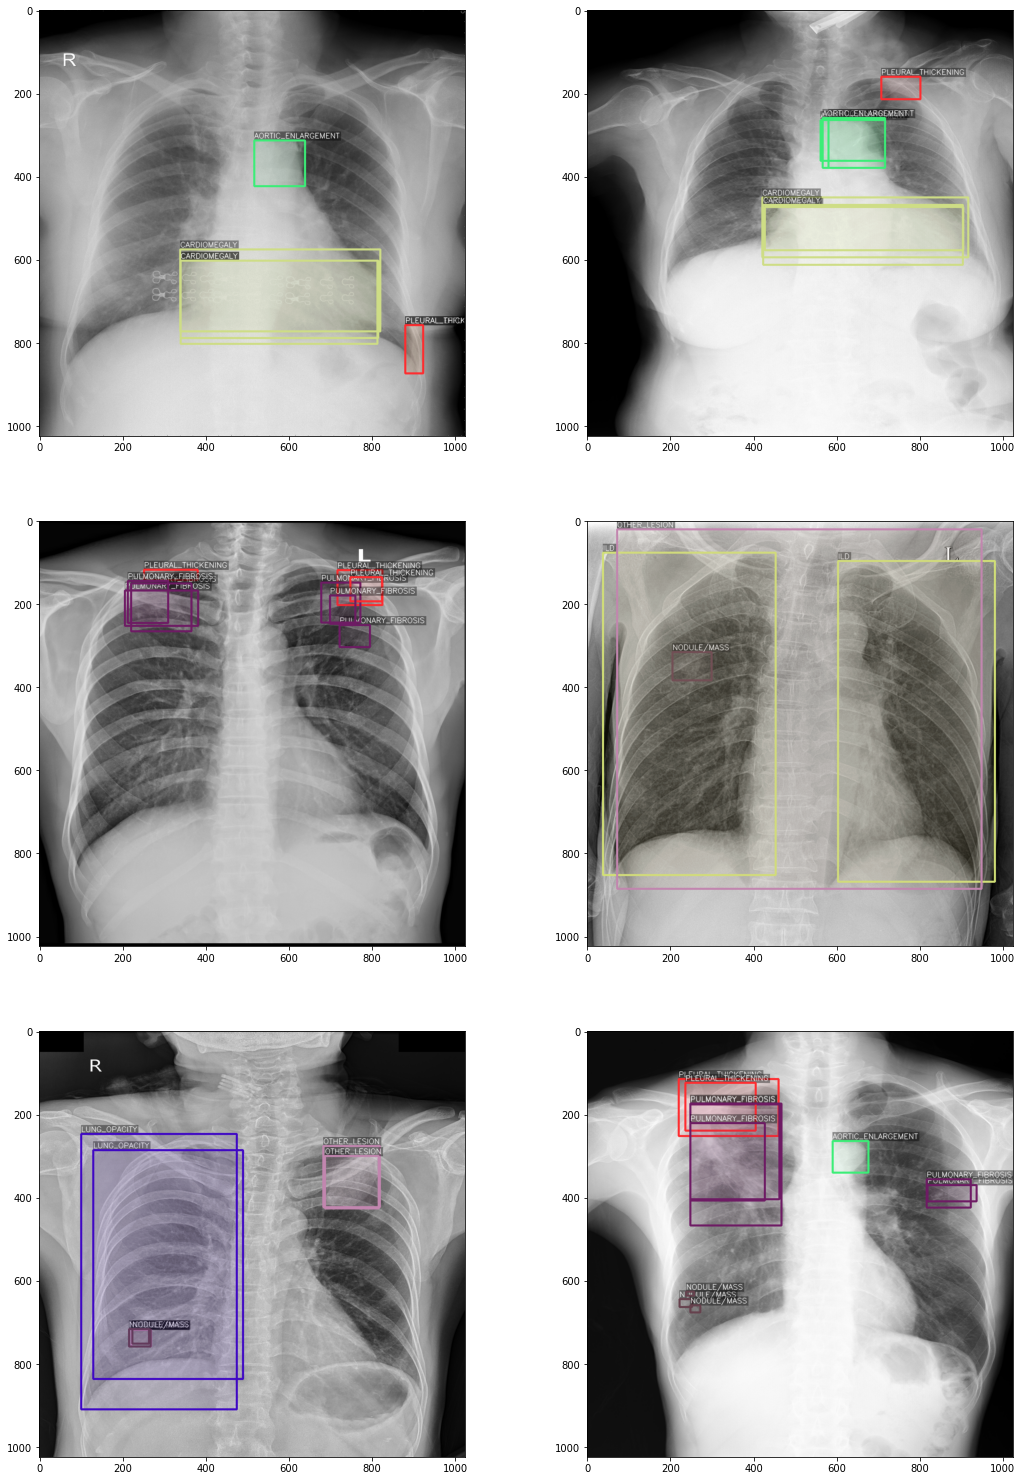

In [ ]:
imgs = []
import cv2
for img_id, path in zip(df_for_plot['image_id'][:6], df_for_plot['image_path'][:6]):
    path = "train/" + path
    boxes = df_for_plot.loc[df_for_plot['image_id']==img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values
    img_labels = df_for_plot.loc[df_for_plot['image_id']==img_id, ['class_id']].values.squeeze()
    img = cv2.imread(path)
    for label_id, box in zip(img_labels, boxes):
        color = label2color[label_id]
        #if box[2] > 1000 or box[3] > 1000:
        img = draw_bbox(img, list(np.int_(box)), viz_labels[label_id], color)
    imgs.append(img)
plot_imgs(imgs, size=9, cmap=None)
plt.show()

- Exploring Techniques to Combine Bboxes
- Non-maximum Suppression (NMS)

In [ ]:
!pip install path
from path import Path
imagepaths = ("train/" + df_for_plot['image_path']).unique()
print("Number of Images with abnormalities:",len(imagepaths))
anno_count = df_for_plot.shape[0]
print("Number of Annotations with abnormalities:", anno_count)
Path("train/" + imagepaths[0] + ".png").stem

Number of Images with abnormalities: 4394
Number of Annotations with abnormalities: 36096


'9a5094b2563a1ef3ff50dc5c7ff71345.png'

- WBF GoGo

In [ ]:
import gc
gc.collect()

97

In [ ]:
!pip install ensemble_boxes
from ensemble_boxes import *
import warnings
from collections import Counter
from tqdm import tqdm
import cv2
iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []
paths = []
total_boxes = []
total_labels = []
for i, path in tqdm(enumerate(imagepaths)):

    image_basename = Path(path).stem
    img_annotations = df_for_plot[df_for_plot.image_id==image_basename]

    boxes_viz = img_annotations[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().tolist()
    labels_viz = img_annotations['class_id'].to_numpy().tolist()
    
    boxes_list = []
    scores_list = []
    labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    
    cls_ids = img_annotations['class_id'].unique().tolist()
    count_dict = Counter(img_annotations['class_id'].tolist())
    #print(count_dict)

    for cid in cls_ids:       
        ## Performing Fusing operation only for multiple bboxes with the same label
        if count_dict[cid]==1:
            labels_single.append(cid)
            boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())

        else:
            cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
            labels_list.append(cls_list)
            bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
            bbox = bbox/(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE)
            bbox = np.clip(bbox, 0, 1)
            boxes_list.append(bbox.tolist())
            scores_list.append(np.ones(len(cls_list)).tolist())

            weights.append(1)
            
    # Perform NMS
    #print(boxes)
    if len(boxes_list) > 0:
        boxes, scores, box_labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
        print("len weight check:", len(weights)==len(boxes))
        boxes = boxes*(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE)
        boxes = boxes.round(1).tolist()
        box_labels = box_labels.astype(int).tolist()

    boxes.extend(boxes_single)

    box_labels.extend(labels_single)

    paths.extend([path]*len(boxes))
    total_boxes.extend(boxes)
    total_labels.extend(box_labels)

17it [00:00, 82.59it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check:

33it [00:00, 78.48it/s]

 False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False


51it [00:00, 81.72it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False


68it [00:00, 80.85it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False


86it [00:01, 83.23it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


104it [00:01, 84.55it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False


123it [00:01, 86.17it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False


142it [00:01, 87.36it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check:

161it [00:01, 88.16it/s]

 False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False


182it [00:02, 91.26it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False


202it [00:02, 90.19it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False


222it [00:02, 88.26it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False


242it [00:02, 91.88it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True


263it [00:03, 95.49it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False


283it [00:03, 92.11it/s]

len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False


302it [00:03, 87.44it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check:

321it [00:03, 90.86it/s]

 True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False


340it [00:03, 88.80it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False


359it [00:04, 89.24it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True


379it [00:04, 93.78it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


399it [00:04, 91.14it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


419it [00:04, 92.43it/s]

len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True


440it [00:04, 96.35it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False


461it [00:05, 96.54it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check:

481it [00:05, 90.62it/s]

 True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


503it [00:05, 95.55it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check:

523it [00:05, 91.76it/s]

 True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


543it [00:06, 89.87it/s]

len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True


564it [00:06, 88.59it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True


585it [00:06, 92.10it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False


605it [00:06, 87.95it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True


626it [00:06, 90.80it/s]

len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True


646it [00:07, 91.66it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False


665it [00:07, 88.82it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False


684it [00:07, 89.54it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


702it [00:07, 83.61it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False


724it [00:08, 92.63it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False


744it [00:08, 87.24it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True


763it [00:08, 89.66it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True


783it [00:08, 90.30it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False


802it [00:08, 88.93it/s]

len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True


822it [00:09, 92.87it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False


841it [00:09, 87.23it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True


860it [00:09, 88.39it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True


880it [00:09, 92.21it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False


901it [00:10, 95.94it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False


921it [00:10, 89.49it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False


941it [00:10, 89.69it/s]

len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False


962it [00:10, 93.07it/s]

len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False


983it [00:10, 96.02it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True


1004it [00:11, 96.07it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True


1024it [00:11, 94.78it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False


1045it [00:11, 94.10it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


1065it [00:11, 92.92it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False


1085it [00:12, 95.53it/s]

len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False


1105it [00:12, 91.66it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False


1125it [00:12, 93.24it/s]

len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False


1145it [00:12, 90.22it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False


1166it [00:12, 93.49it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: 

1187it [00:13, 93.25it/s]

False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True


1207it [00:13, 87.91it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check:

1227it [00:13, 89.75it/s]

 False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True


1247it [00:13, 90.39it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


1267it [00:14, 92.31it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


1288it [00:14, 92.29it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False


1308it [00:14, 91.00it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False


1330it [00:14, 95.17it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False


1351it [00:14, 95.88it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


1372it [00:15, 96.59it/s]

len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False


1393it [00:15, 92.12it/s]

len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True


1413it [00:15, 88.85it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


1433it [00:15, 92.66it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False


1454it [00:16, 94.56it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True


1475it [00:16, 95.63it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True


1496it [00:16, 95.70it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True


1516it [00:16, 95.14it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False


1536it [00:16, 94.41it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False


1557it [00:17, 92.43it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True


1577it [00:17, 93.55it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False

1597it [00:17, 91.54it/s]


len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check:

1619it [00:17, 94.98it/s]

 True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True


1641it [00:17, 98.31it/s]

len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


1662it [00:18, 96.96it/s]

len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False


1683it [00:18, 97.26it/s]

len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check:

1704it [00:18, 99.63it/s]

 True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False


1726it [00:18, 101.17it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True


1748it [00:19, 101.98it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check:

1770it [00:19, 99.77it/s] 

 True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


1790it [00:19, 96.08it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False


1810it [00:19, 91.75it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False


1829it [00:19, 85.68it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check:

1850it [00:20, 93.35it/s]

 False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


1871it [00:20, 96.05it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True


1891it [00:20, 95.25it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True


1913it [00:20, 98.71it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False


1935it [00:21, 97.76it/s] 

len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check:

1956it [00:21, 96.02it/s]

 True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False


1976it [00:21, 93.64it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False


1997it [00:21, 96.90it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False


2018it [00:21, 96.03it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True


2038it [00:22, 95.30it/s]

len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False


2060it [00:22, 100.40it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False


2082it [00:22, 94.03it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check:

2104it [00:22, 98.00it/s]

 True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True


2125it [00:22, 98.30it/s]

len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True


2148it [00:23, 100.51it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


2169it [00:23, 90.23it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False


2189it [00:23, 92.01it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True


2211it [00:23, 97.56it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False


2231it [00:24, 97.09it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False


2253it [00:24, 100.60it/s]

len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False


2275it [00:24, 99.85it/s]

len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True


2298it [00:24, 104.42it/s]

len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check:

2320it [00:24, 103.04it/s]

 True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False


2341it [00:25, 94.17it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True


2361it [00:25, 92.78it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check:

2383it [00:25, 98.71it/s]

 True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False


2403it [00:25, 96.55it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False


2424it [00:26, 97.79it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check:

2444it [00:26, 96.85it/s]

 False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False


2466it [00:26, 101.18it/s]

len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True


2487it [00:26, 97.62it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True


2509it [00:26, 100.44it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False


2532it [00:27, 103.93it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False


2554it [00:27, 100.23it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check:

2576it [00:27, 97.53it/s] 

 False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check:

2596it [00:27, 97.91it/s]

 False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False


2619it [00:27, 102.02it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False


2640it [00:28, 97.70it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False


2661it [00:28, 98.02it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True


2681it [00:28, 90.50it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False


2704it [00:28, 99.11it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True


2726it [00:29, 98.17it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True


2748it [00:29, 100.81it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True


2771it [00:29, 103.13it/s]

len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check:

2793it [00:29, 97.70it/s] 

 False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False


2814it [00:29, 99.30it/s]

len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check:

2835it [00:30, 99.76it/s]

 False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False


2857it [00:30, 102.02it/s]

len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False


2879it [00:30, 102.46it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False


2900it [00:30, 97.85it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check:

2921it [00:31, 98.70it/s]

 False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True


2943it [00:31, 99.61it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False


2965it [00:31, 100.38it/s]

len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True


2987it [00:31, 99.98it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True


3009it [00:31, 103.73it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False


3031it [00:32, 99.77it/s] 

len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False


3053it [00:32, 96.19it/s]

len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False


3073it [00:32, 95.64it/s]

len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check:

3096it [00:32, 97.43it/s]

 True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False


3116it [00:33, 96.08it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False


3137it [00:33, 93.88it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False


3159it [00:33, 98.24it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check:

3181it [00:33, 101.88it/s]

 False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True


3215it [00:33, 105.13it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False


3226it [00:34, 98.10it/s] 

len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True


3246it [00:34, 92.18it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False


3266it [00:34, 90.25it/s]

len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


3287it [00:34, 96.40it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False


3307it [00:35, 95.14it/s]

len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False


3329it [00:35, 98.67it/s]

len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True


3351it [00:35, 99.91it/s] 

len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True


3373it [00:35, 100.23it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True

3396it [00:35, 102.99it/s]


len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False


3418it [00:36, 104.07it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False


3442it [00:36, 106.42it/s]

len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True


3464it [00:36, 105.24it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False


3487it [00:36, 103.84it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True


3509it [00:36, 103.77it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True


3532it [00:37, 104.10it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True


3556it [00:37, 108.80it/s]

len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True


3579it [00:37, 110.37it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False


3602it [00:37, 106.48it/s]

len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True


3625it [00:38, 108.31it/s]

len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False


3649it [00:38, 109.43it/s]

len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check:

3673it [00:38, 113.36it/s]

 True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True


3698it [00:38, 111.14it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True


3722it [00:38, 109.61it/s]

len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False


3745it [00:39, 108.19it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True


3770it [00:39, 110.64it/s]

len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check:

3794it [00:39, 110.60it/s]

 False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True


3818it [00:39, 108.93it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True


3841it [00:39, 111.40it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False


3865it [00:40, 109.34it/s]

len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True


3888it [00:40, 111.63it/s]

len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check:

3912it [00:40, 112.33it/s]

 False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True


3936it [00:40, 109.64it/s]

len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True


3958it [00:41, 108.37it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True


3983it [00:41, 112.46it/s]

len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False


4008it [00:41, 115.58it/s]

len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False


4032it [00:41, 116.71it/s]

len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False


4056it [00:41, 113.31it/s]

len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True


4082it [00:42, 116.52it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False


4106it [00:42, 115.41it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True


4131it [00:42, 116.87it/s]

len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True


4156it [00:42, 117.72it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True


4180it [00:42, 116.22it/s]

len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False


4204it [00:43, 116.68it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True


4232it [00:43, 125.32it/s]

len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False


4259it [00:43, 123.99it/s]

len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check:

4285it [00:43, 122.52it/s]

 True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False


4310it [00:44, 118.39it/s]

len weight check: False
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True


4335it [00:44, 120.11it/s]

len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check:

4375it [00:44, 125.60it/s]

 True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True


4394it [00:44, 98.35it/s] 

len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: False
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True
len weight check: True


In [ ]:
df_backup_backup = df_backup.loc[df_backup['class_id']!=14].reset_index(drop=True)
class_dict = {x:y for x,y in zip(df_backup_backup.class_id.tolist(), df_backup_backup.class_name.tolist())}

df = pd.DataFrame({'image_id':map(lambda x: x.split("/")[-1].split(".")[0], paths), 'class_id':total_labels})
df_coords = pd.DataFrame(total_boxes, columns=['x_min', 'y_min', 'x_max', 'y_max'])
df = pd.concat([df, df_coords], axis=1)
df['class_name'] = df['class_id'].map(class_dict)

- PreProcessing total df

In [ ]:
class_ids, class_names = list(zip(*set(zip(df.class_id, df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
class_dict = {x:y for x,y in zip(class_ids, class_names)}

In [ ]:
df['x_mid'] = df.apply(lambda row: (row.x_max + row.x_min) / 2, axis=1)
df['y_mid'] = df.apply(lambda row: (row.y_max + row.y_min) / 2, axis=1)

df['w'] = df.apply(lambda row: (row.x_max - row.x_min), axis=1)
df['h'] = df.apply(lambda row: (row.y_max - row.y_min), axis=1)

df['area'] = df['w']*df['h']
df.head()

,image_id,class_id,x_min,y_min,x_max,y_max,class_name,x_mid,y_mid,w,h,area
0,9a5094b2563a1ef3ff50dc5c7ff71345,3,339.7,593.0,816.0,787.3,Cardiomegaly,577.85,690.15,476.3,194.3,92545.09
1,9a5094b2563a1ef3ff50dc5c7ff71345,10,880.0,757.0,923.0,873.0,Pleural effusion,901.50,815.00,43.0,116.0,4988.00
2,9a5094b2563a1ef3ff50dc5c7ff71345,11,880.0,757.0,923.0,873.0,Pleural thickening,901.50,815.00,43.0,116.0,4988.00
3,9a5094b2563a1ef3ff50dc5c7ff71345,0,517.0,313.0,639.0,423.0,Aortic enlargement,578.00,368.00,122.0,110.0,13420.00
4,051132a778e61a86eb147c7c6f564dfe,3,423.7,463.7,907.7,594.3,Cardiomegaly,665.70,529.00,484.0,130.6,63210.40


In [ ]:
df_backup = df_backup[['image_id','width','height']].drop_duplicates()
df = pd.merge(df, df_backup[['image_id','width','height']], how='left', on='image_id')
df.loc[:,['x_mid', 'y_mid', 'w', 'h']] = df.loc[:,['x_mid', 'y_mid', 'w', 'h']] / IMAGE_SIZE
df_folds = df[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()

In [ ]:
df_folds.loc[:, 'object_count'] = df.groupby('image_id')['class_id'].nunique()
df_folds.loc[:, 'stratify_group'] = np.char.add(df_folds['object_count'].values.astype(str), df_folds['bbox_count'].apply(lambda x: f'_{x//15}').values.astype(str))

In [ ]:
df_folds.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

In [ ]:
#print(fold)
#df_train = pd.merge(df, df_folds[df_folds['fold']!=fold], on='image_id')
#df_valid = pd.merge(df, df_folds[df_folds['fold']==fold], on='image_id')
anno_original = pd.concat([pd.merge(df, df_folds[df_folds['fold']==0], on='image_id'),
                  pd.merge(df, df_folds[df_folds['fold']==1], on='image_id'),
                  pd.merge(df, df_folds[df_folds['fold']==2], on='image_id')], axis=0).reset_index(drop=True)
#figure(figsize=(30, 8))
#df_train['class_name'].hist()
#df_valid['class_name'].hist()

In [ ]:
anno_original['y_min'].max()

986.0

## Train data generation

In [ ]:
import shutil
from tqdm import tqdm
if True:
    for fold in [0,1,2,3,4]:
        df_train = pd.merge(df, df_folds[df_folds['fold']!=fold], on='image_id')
        for name,mini in tqdm(df_train.groupby('image_id')):
            path2save = 'train2017/'
            if not os.path.exists('convertor/fold_{}/labels/'.format(fold)+path2save):
                os.makedirs('convertor/fold_{}/labels/'.format(fold)+path2save)
            with open('convertor/fold_{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['class_id','x_mid','y_mid','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('convertor/fold_{}/images/{}'.format(fold,path2save)):
                os.makedirs('convertor/fold_{}/images/{}'.format(fold,path2save))
            shutil.copy("train/{}.png".format(name),'convertor/fold_{}/images/{}/{}.png'.format(fold,path2save,name))

100%|██████████| 3516/3516 [00:19<00:00, 177.96it/s]


## Validation Data Generation

In [ ]:
import shutil
from tqdm import tqdm
if True:
    for fold in [0,1,2,3,4]:
        df_valid = pd.merge(df, df_folds[df_folds['fold']==fold], on='image_id')
        for name,mini in tqdm(df_valid.groupby('image_id')):
            path2save = 'valid2017/'
            if not os.path.exists('convertor/fold_{}/labels/'.format(fold)+path2save):
                os.makedirs('convertor/fold_{}/labels/'.format(fold)+path2save)
            with open('convertor/fold_{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['class_id','x_mid','y_mid','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('convertor/fold_{}/images/{}'.format(fold,path2save)):
                os.makedirs('convertor/fold_{}/images/{}'.format(fold,path2save))
            shutil.copy("train/{}.png".format(name),'convertor/fold_{}/images/{}/{}.png'.format(fold,path2save,name))

100%|██████████| 878/878 [00:05<00:00, 172.87it/s]


# Make yaml file

In [ ]:
from os import listdir
from os.path import isfile, join
import yaml
import glob

#cwd = './ '
for fold in [fold]:
    with open(f'train{fold}.txt', 'w') as f:

        for path in glob.glob(f'convertor/fold_{fold}/images/train2017/*png'):
            print(path)
            f.write(path+'\n')
            
    with open(f'val{fold}.txt', 'w') as f:
        for path in glob.glob(f'convertor/fold_{fold}/images/valid2017/*png'):
            f.write(path+'\n')

data = dict(
    train =  f'train{fold}.txt',
    val   =  f'val{fold}.txt',
    nc    = 14,
    names = classes
    )

with open(join(f'vinbigdata_fold{fold}.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join(f'vinbigdata_fold{fold}.yaml'), 'r')
print('\nyaml:')
print(f.read())

convertor/fold_4/images/train2017/de45e56d725f9c1e2d3dec69587b2682.png
convertor/fold_4/images/train2017/458dac26200d54d8be49a43e001dc7da.png
convertor/fold_4/images/train2017/3e802de7dd2a052ff980de1ff50262ee.png
convertor/fold_4/images/train2017/f5647785cac236ffe0ec3287f9f6aa84.png
convertor/fold_4/images/train2017/14f8770d112738119f0f31ee75e8fc41.png
convertor/fold_4/images/train2017/898aa25e4ce627843fa8ea0607a0cfc8.png
convertor/fold_4/images/train2017/0622cd29e4e0e4f198abf15614819ae8.png
convertor/fold_4/images/train2017/debcc0c8e3b22dd08b85037c91da1df7.png
convertor/fold_4/images/train2017/d5eaa2c2ae8e05956394f24470224843.png
convertor/fold_4/images/train2017/a47a8dbe0f480f7ce3abfb0b9d880afa.png
convertor/fold_4/images/train2017/0c5ef740a9befbf439439f0b8e652a0c.png
convertor/fold_4/images/train2017/82624b37dc4d0169f3fe6fd87dcb5208.png
convertor/fold_4/images/train2017/c4e8d9bb21040cbe94f1763856bfcfe2.png
convertor/fold_4/images/train2017/0cf83a19a8281e4a281dece9854008ac.png
conver

In [ ]:
!cp gdrive/My\ Drive/Colab\ Notebooks/vin_save/best_fold0_imsize[1024,\ 1024].pt .
!cp gdrive/My\ Drive/Colab\ Notebooks/vin_save/best_fold1_imsize[1024,\ 1024].pt .
!cp gdrive/My\ Drive/Colab\ Notebooks/vin_save/best_fold2_imsize[1024,\ 1024].pt .

In [ ]:
# With WBF
!python train.py --img 1024 --batch 4 --epochs 16 --data vinbigdata.yaml --weights best_fold2_imsize[1024,\ 1024].pt --fold $fold

github: skipping check (not a git repository)
YOLOv5 🚀  torch 1.8.1+cu101 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Namespace(adam=False, batch_size=4, bucket='', cache_images=False, cfg='', data='vinbigdata.yaml', device='', entity=None, epochs=16, evolve=False, exist_ok=False, fold=2, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[1024, 1024], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp', single_cls=False, sync_bn=False, total_batch_size=4, weights='best_fold2_imsize[1024, 1024].pt', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2021-04-05 03:01:19.081878: I tensorflow/stream_executor/platform/default/dso_loader.cc:

# Inference or Evaluation

In [ ]:
from google.colab import files
files.upload()

Saving test.csv to test.csv


{'test.csv': b'image_id,width,height\n83caa8a85e03606cf57e49147d7ac569,2304,2880\n7550347fa2bb96c2354a3716dfa3a69c,2538,3095\n74b23792db329cff5843e36efb8aa65a,2788,3120\n94568a546be103177cb582d3e91cd2d8,1994,2430\n6da36354fc904b63bc03eb3884e0c35c,2056,2376\n5b3620a56668010877cfafa9322e18b5,2336,2788\n5157d5c9b1f0004b29310652ea54e825,2517,3028\n74897408dcbd69ef7c76cbbbbeb722d6,3072,3072\n271290de7e7e4fb8aa1c31327f48f4b5,2067,2492\ncdb9c0046cc8f9e32fcafc5517000525,3072,3072\neb4c1f7a8fcd7ee076ae9f5eca8d05fc,1994,2430\n366fb4e84d6940ea74267b32edbd1311,3072,3072\nf5f77203f00504c40b45a65d23cd8948,2504,2930\n212dc39b6ba6941b034c2cd92cf97a8d,3072,3072\na5eabc3dd2734b211c9b09205443a2ea,2336,2836\nc374e62c67f8e7a4d460e37d56bfa852,2231,2398\ncb3b210015a31adab114493e1150eaf8,1994,2430\n6cbf4295b5b72bc01ef6fd171ef7733e,2276,2446\n564141a415cfa32841bb2de146faa5eb,3000,3000\nfc28fc9ede2c505c2125343c048124b6,2336,2472\n2f775125346cd62232d8e835794941c0,2321,2742\n1fae839a73abec3f3d7436fa2bce4630,2048,

In [ ]:
test_df = pd.read_csv('vin/test.csv')
#test_df = df_valid.copy()
IMAGE_SIZE = 768

In [ ]:
test_df.head()

,image_id,width,height
0,83caa8a85e03606cf57e49147d7ac569,2304,2880
1,7550347fa2bb96c2354a3716dfa3a69c,2538,3095
2,74b23792db329cff5843e36efb8aa65a,2788,3120
3,94568a546be103177cb582d3e91cd2d8,1994,2430
4,6da36354fc904b63bc03eb3884e0c35c,2056,2376


- A check if weight exists

In [ ]:
#for test
import glob
def deletetext():
  for i in range(5):
    for x in glob.glob(f'runs{fold}/detect/exp/labels/*txt'):
        os.remove(x)
deletetext()

In [ ]:
import gc
gc.collect()

320

# For Validation Inference

In [ ]:
!python detect.py --weights best_fold0_imsize[1024,\ 1024].pt --img $IMAGE_SIZE --conf 0.001 --iou 0.3 --source convertor/fold_0/images/valid2017 --save-txt --save-conf --exist-ok --project runs0/detect/
!python detect.py --weights best_fold1_imsize[1024,\ 1024].pt --img $IMAGE_SIZE --conf 0.001 --iou 0.3 --source convertor/fold_1/images/valid2017 --save-txt --save-conf --exist-ok --project runs1/detect/ 
!python detect.py --weights best_fold2_imsize[1024,\ 1024].pt --img $IMAGE_SIZE --conf 0.001 --iou 0.3 --source convertor/fold_2/images/valid2017 --save-txt --save-conf --exist-ok --project runs2/detect/ 
#!python detect.py --weights best_fold3_imsize[1024,\ 1024].pt --img 768 --conf 0.001 --iou 0.4 --source convertor/fold_3/images/valid2017 --save-txt --save-conf --exist-ok --project runs3/detect/ 
#!python detect.py --weights best_fold4_imsize[1024,\ 1024].pt --img 768 --conf 0.001 --iou 0.4 --source convertor/fold_4/images/valid2017 --save-txt --save-conf --exist-ok --project runs4/detect/ 

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.001, device='', exist_ok=True, img_size=768, iou_thres=0.3, name='exp', project='runs0/detect/', save_conf=True, save_txt=True, source='convertor/fold_0/images/valid2017', update=False, view_img=False, weights=['best_fold0_imsize[1024, 1024].pt'])
YOLOv5 🚀  torch 1.8.1+cu101 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 476 layers, 87286171 parameters, 0 gradients, 217.4 GFLOPS
image 1/879 /content/convertor/fold_0/images/valid2017/0061cf6d35e253b6e7f03940592cc35e.png: 768x768 1 Aortic enlargement, 1 Atelectasis, 5 Calcifications, 2 Infiltrations, 3 Lung Opacitys, 5 Nodule/Masss, 6 Other lesions, 1 Pleural effusion, 4 Pleural thickenings, 7 Pulmonary fibrosiss, Done. (0.057s)
image 2/879 /content/convertor/fold_0/images/valid2017/00675cd546313f912cadd4ad54415d69.png: 768x768 3 Aortic enlargements, 2 Calcifications, 2 Cardiomegalys, 4 Other lesions, 1 Pleural effusion, 7 Pleural thicke

# Inference Plot

In [ ]:
def yolo2voc(image_height, image_width, bboxes):
    bboxes = bboxes.copy().astype(float)
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]] * image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]] * image_height

    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - (bboxes[..., [2, 3]] / 2)
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]

    return bboxes

In [ ]:
import glob
image_ids = []
PredictionStrings = []

for file_path in tqdm(glob.glob('runs2/detect/exp/labels/*txt')):
    image_id = file_path.split('/')[-1].split('.')[0]
    w, h = test_df.loc[test_df.image_id==image_id,['width', 'height']].values[0]
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
    data = data[:, [0, 5, 1, 2, 3, 4]]
    bboxes = list(np.round(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1), 1).astype(str))
    for idx in range(len(bboxes)):
        bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
    image_ids.append(image_id)
    PredictionStrings.append(' '.join(bboxes))

100%|██████████| 3000/3000 [00:06<00:00, 460.14it/s]


# For NMS IOU THRESHOLD AT 0.5

In [ ]:
def yolo2xyxy(image_height, image_width, bboxes):
    bboxes = bboxes.copy().astype(float)
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]] * image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]] * image_height

    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - (bboxes[..., [2, 3]] / 2)
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]

    return bboxes

# Total Concat For Inference

In [ ]:
test_df = pd.read_csv('vin/test.csv')
import glob
image_ids = []
total_concats = []
for fold in [0,1,2]:
    total_concat = pd.DataFrame({'image_id':[], 'class_id':[], 'pred':[], 'x_min':[], 'y_min':[], 'x_max':[], 'y_max':[]})
    for i, file_path in enumerate(glob.glob(f'runs{fold}/detect/exp/labels/*txt')):
        image_id = file_path.split('/')[-1].split('.')[0]
        w, h = test_df.loc[test_df.image_id==image_id,['width', 'height']].values[0]
        w, h = IMAGE_SIZE, IMAGE_SIZE
        f = open(file_path, 'r')
        data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
        data = data[:, [0, 5, 1, 2, 3, 4]]
        data = np.concatenate((data[:, :2], np.round(yolo2xyxy(h, w, data[:, 2:]))), axis =1)
        temp_concat = pd.DataFrame({'image_id':[image_id]*len(data), 'class_id':data[:,0], 'pred':data[:,1], 'x_min':data[:,2], 'y_min':data[:,3], 'x_max':data[:,4], 'y_max':data[:,5]})
        total_concat = pd.concat([total_concat, temp_concat], axis=0)
    total_concats.append(total_concat)
    
print(total_concats)

# Total Concat For Validation

In [ ]:
val = True
import glob
image_ids = []
total_concats = []
for fold in [0,1,2]:
    total_concat = pd.DataFrame({'image_id':[], 'class_id':[], 'pred':[], 'x_min':[], 'y_min':[], 'x_max':[], 'y_max':[]})
    for i, file_path in enumerate(glob.glob(f'runs{fold}/detect/exp/labels/*txt')):
        image_id = file_path.split('/')[-1].split('.')[0]
        #w, h = test_df.loc[test_df.image_id==image_id,['width', 'height']].values[0]
        w, h = IMAGE_SIZE, IMAGE_SIZE
        f = open(file_path, 'r')
        data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
        data = data[:, [0, 5, 1, 2, 3, 4]]
        data = np.concatenate((data[:, :2], np.round(yolo2xyxy(IMAGE_SIZE, IMAGE_SIZE, data[:, 2:]))), axis =1)
        temp_concat = pd.DataFrame({'image_id':[image_id]*len(data), 'class_id':data[:,0], 'pred':data[:,1], 'x_min':data[:,2], 'y_min':data[:,3], 'x_max':data[:,4], 'y_max':data[:,5]})
        total_concat = pd.concat([total_concat, temp_concat], axis=0)
    total_concats.append(total_concat)
if val:
    total_concats = [pd.concat(total_concats, axis=0)]
    
print(total_concats)
    #data[:,2:] = data[:,2:]
    #bboxes = list(np.round(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1), 1).astype(str))
    #for idx in range(len(bboxes)):
    #    bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
    #image_ids.append(image_id)
    #PredictionStrings.append(' '.join(bboxes))

In [ ]:
total_concats[0]['x_max'].max()

768.0

#Ensemble WBF For Validation

In [ ]:
!pip install ensemble_boxes
from ensemble_boxes import *
import warnings
from collections import Counter
from tqdm import tqdm

from path import Path
#test_imagepaths = ("test/" + total_concat['image_id'] + ".png").unique()
print("Number of Images with abnormalities:",len(test_imagepaths))
anno_count = df_for_plot.shape[0]
print("Number of Annotations with abnormalities:", anno_count)
Path("train/" + imagepaths[0] + ".png").stem
train_imagepaths = ("train/" + pd.concat(total_concats, axis=0)['image_id'] + ".png").unique()
iou_thr = 0.4
skip_box_thr = 0.0001
viz_images = []
paths = []
total_boxes = []
total_labels = []
total_scores = []
for i, path in tqdm(enumerate(train_imagepaths)):

    image_basename = Path(path).stem
    total_boxes_list = []
    total_scores_list = []
    total_labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    scores_single = []


    for total_concat in total_concats:
        boxes_list = []
        scores_list = []
        labels_list = []

        img_annotations = total_concat[total_concat.image_id==image_basename]
        cls_ids = img_annotations['class_id'].unique().tolist()
        count_dict = Counter(img_annotations['class_id'].tolist())
        for cid in cls_ids:       
        ## Performing Fusing operation only for multiple bboxes with the same label
            if count_dict[cid]==1:
                labels_single.append(cid)
                boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())
                scores_single.append(img_annotations[img_annotations.class_id==cid][['pred']].to_numpy().squeeze().tolist())

            else:
                cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
                labels_list.extend(cls_list)
                bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
                bbox = bbox/(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE)
                bbox = np.clip(bbox, 0, 1)
                score = img_annotations[img_annotations.class_id==cid][['pred']].to_numpy().squeeze().tolist()
                boxes_list.extend(bbox.tolist())
                scores_list.extend(score)
        total_boxes_list.append(boxes_list)
        total_scores_list.append(scores_list)
        total_labels_list.append(labels_list)
                #weights.append(1)
            
    # Perform NMS
    if len(total_boxes_list[0]) > 0:
        boxes, scores, box_labels = weighted_boxes_fusion(total_boxes_list, total_scores_list, total_labels_list, weights=[1]*len(total_concats),
                                                          iou_thr=iou_thr, conf_type='max')
        boxes = boxes*(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE)
        boxes = boxes.round(1).tolist()
        box_labels = box_labels.astype(int).tolist()
        scores = scores.tolist()

    boxes.extend(boxes_single)

    box_labels.extend(labels_single)
    scores.extend(scores_single)
    
    paths.extend([path]*len(boxes))
    total_boxes.extend(boxes)
    total_labels.extend(box_labels)
    total_scores.extend(scores)
    print("Bboxes after nms:\n", len(boxes))

# Ensemble WBF For Inference

In [ ]:
!pip install ensemble_boxes
from ensemble_boxes import *
import warnings
from collections import Counter
from tqdm import tqdm

from path import Path
test_imagepaths = ("test/" + total_concat['image_id'] + ".png").unique()
print("Number of Images with abnormalities:",len(test_imagepaths))
anno_count = df_for_plot.shape[0]
print("Number of Annotations with abnormalities:", anno_count)
Path("train/" + imagepaths[0] + ".png").stem

iou_thr = 0.5
skip_box_thr = 0.0001
viz_images = []
paths = []
total_boxes = []
total_labels = []
total_scores = []
for i, path in tqdm(enumerate(test_imagepaths)):

    image_basename = Path(path).stem
    total_boxes_list = []
    total_scores_list = []
    total_labels_list = []
    weights = []
    
    boxes_single = []
    labels_single = []
    scores_single = []


    for total_concat in total_concats:
        boxes_list = []
        scores_list = []
        labels_list = []

        img_annotations = total_concat[total_concat.image_id==image_basename]
        cls_ids = img_annotations['class_id'].unique().tolist()
        count_dict = Counter(img_annotations['class_id'].tolist())
        for cid in cls_ids:       
        ## Performing Fusing operation only for multiple bboxes with the same label
            if count_dict[cid]==1:
                labels_single.append(cid)
                boxes_single.append(img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy().squeeze().tolist())
                scores_single.append(img_annotations[img_annotations.class_id==cid][['pred']].to_numpy().squeeze().tolist())

            else:
                cls_list =img_annotations[img_annotations.class_id==cid]['class_id'].tolist()
                labels_list.extend(cls_list)
                bbox = img_annotations[img_annotations.class_id==cid][['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
            ## Normalizing Bbox by Image Width and Height
                bbox = bbox/(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE)
                bbox = np.clip(bbox, 0, 1)
                score = img_annotations[img_annotations.class_id==cid][['pred']].to_numpy().squeeze().tolist()
                boxes_list.extend(bbox.tolist())
                scores_list.extend(score)
        total_boxes_list.append(boxes_list)
        total_scores_list.append(scores_list)
        total_labels_list.append(labels_list)
                #weights.append(1)
            
    # Perform NMS
    if len(total_boxes_list[0]) > 0:
        boxes, scores, box_labels = weighted_boxes_fusion(total_boxes_list, total_scores_list, total_labels_list, weights=[1]*len(total_concats), iou_thr=iou_thr)
        boxes = boxes*(IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE, IMAGE_SIZE)
        boxes = boxes.round(1).tolist()
        box_labels = box_labels.astype(int).tolist()
        scores = scores.tolist()

    boxes.extend(boxes_single)

    box_labels.extend(labels_single)
    scores.extend(scores_single)
    
    paths.extend([path]*len(boxes))
    total_boxes.extend(boxes)
    total_labels.extend(box_labels)
    total_scores.extend(scores)
    print("Bboxes after nms:\n", len(boxes))

2it [00:00, 17.86it/s]

Number of Images with abnormalities: 2637
Number of Annotations with abnormalities: 36096
Bboxes after nms:
 24
Bboxes after nms:
 155
Bboxes after nms:
 25


7it [00:00, 19.31it/s]

Bboxes after nms:
 94
Bboxes after nms:
 43
Bboxes after nms:
 41
Bboxes after nms:
 25
Bboxes after nms:
 9


10it [00:00, 17.94it/s]

Bboxes after nms:
 102
Bboxes after nms:
 222
Bboxes after nms:
 151


14it [00:00, 16.45it/s]

Bboxes after nms:
 134
Bboxes after nms:
 18
Bboxes after nms:
 177
Bboxes after nms:
 29


19it [00:01, 17.34it/s]

Bboxes after nms:
 52
Bboxes after nms:
 32
Bboxes after nms:
 58
Bboxes after nms:
 45


23it [00:01, 17.13it/s]

Bboxes after nms:
 56
Bboxes after nms:
 24
Bboxes after nms:
 70
Bboxes after nms:
 103


27it [00:01, 16.36it/s]

Bboxes after nms:
 92
Bboxes after nms:
 132
Bboxes after nms:
 127
Bboxes after nms:
 36


32it [00:01, 18.06it/s]

Bboxes after nms:
 45
Bboxes after nms:
 57
Bboxes after nms:
 24
Bboxes after nms:
 35
Bboxes after nms:
 37


36it [00:02, 17.52it/s]

Bboxes after nms:
 90
Bboxes after nms:
 85
Bboxes after nms:
 127
Bboxes after nms:
 22


41it [00:02, 19.41it/s]

Bboxes after nms:
 107
Bboxes after nms:
 15
Bboxes after nms:
 21
Bboxes after nms:
 32
Bboxes after nms:
 25


43it [00:02, 17.22it/s]

Bboxes after nms:
 70
Bboxes after nms:
 187
Bboxes after nms:
 76
Bboxes after nms:
 24


49it [00:02, 18.73it/s]

Bboxes after nms:
 45
Bboxes after nms:
 23
Bboxes after nms:
 33
Bboxes after nms:
 118
Bboxes after nms:
 33


52it [00:02, 19.39it/s]

Bboxes after nms:
 17
Bboxes after nms:
 109
Bboxes after nms:
 28
Bboxes after nms:
 113


57it [00:03, 18.47it/s]

Bboxes after nms:
 82
Bboxes after nms:
 30
Bboxes after nms:
 151
Bboxes after nms:
 57


62it [00:03, 19.41it/s]

Bboxes after nms:
 121
Bboxes after nms:
 35
Bboxes after nms:
 19
Bboxes after nms:
 40
Bboxes after nms:
 77


67it [00:03, 18.56it/s]

Bboxes after nms:
 79
Bboxes after nms:
 81
Bboxes after nms:
 23
Bboxes after nms:
 176


71it [00:03, 18.92it/s]

Bboxes after nms:
 47
Bboxes after nms:
 60
Bboxes after nms:
 38
Bboxes after nms:
 44
Bboxes after nms:
 61


75it [00:04, 17.72it/s]

Bboxes after nms:
 163
Bboxes after nms:
 75
Bboxes after nms:
 73
Bboxes after nms:
 23
Bboxes after nms:
 30


81it [00:04, 19.15it/s]

Bboxes after nms:
 118
Bboxes after nms:
 22
Bboxes after nms:
 49
Bboxes after nms:
 92
Bboxes after nms:
 35


86it [00:04, 19.75it/s]

Bboxes after nms:
 44
Bboxes after nms:
 102
Bboxes after nms:
 16
Bboxes after nms:
 34
Bboxes after nms:
 92


90it [00:04, 17.96it/s]

Bboxes after nms:
 131
Bboxes after nms:
 123
Bboxes after nms:
 66
Bboxes after nms:
 15


96it [00:05, 18.94it/s]

Bboxes after nms:
 85
Bboxes after nms:
 27
Bboxes after nms:
 83
Bboxes after nms:
 43
Bboxes after nms:
 105


99it [00:05, 19.85it/s]

Bboxes after nms:
 31
Bboxes after nms:
 54
Bboxes after nms:
 32
Bboxes after nms:
 28
Bboxes after nms:
 93


104it [00:05, 19.41it/s]

Bboxes after nms:
 55
Bboxes after nms:
 80
Bboxes after nms:
 26
Bboxes after nms:
 74


109it [00:05, 19.89it/s]

Bboxes after nms:
 67
Bboxes after nms:
 116
Bboxes after nms:
 18
Bboxes after nms:
 40
Bboxes after nms:
 13


115it [00:06, 20.75it/s]

Bboxes after nms:
 29
Bboxes after nms:
 76
Bboxes after nms:
 73
Bboxes after nms:
 45
Bboxes after nms:
 32


118it [00:06, 20.36it/s]

Bboxes after nms:
 49
Bboxes after nms:
 36
Bboxes after nms:
 106
Bboxes after nms:
 28
Bboxes after nms:
 17


124it [00:06, 20.86it/s]

Bboxes after nms:
 11
Bboxes after nms:
 179
Bboxes after nms:
 46
Bboxes after nms:
 48


127it [00:06, 21.22it/s]

Bboxes after nms:
 37
Bboxes after nms:
 37
Bboxes after nms:
 31
Bboxes after nms:
 25
Bboxes after nms:
 126


133it [00:06, 20.02it/s]

Bboxes after nms:
 136
Bboxes after nms:
 31
Bboxes after nms:
 83
Bboxes after nms:
 35
Bboxes after nms:
 93


139it [00:07, 21.78it/s]

Bboxes after nms:
 31
Bboxes after nms:
 53
Bboxes after nms:
 18
Bboxes after nms:
 31
Bboxes after nms:
 12


142it [00:07, 20.17it/s]

Bboxes after nms:
 65
Bboxes after nms:
 139
Bboxes after nms:
 66
Bboxes after nms:
 28
Bboxes after nms:
 19


148it [00:07, 21.13it/s]

Bboxes after nms:
 27
Bboxes after nms:
 38
Bboxes after nms:
 23
Bboxes after nms:
 69


154it [00:08, 19.23it/s]

Bboxes after nms:
 370
Bboxes after nms:
 51
Bboxes after nms:
 23
Bboxes after nms:
 33
Bboxes after nms:
 55
Bboxes after nms:
 34


157it [00:08, 18.84it/s]

Bboxes after nms:
 88
Bboxes after nms:
 20
Bboxes after nms:
 80
Bboxes after nms:
 32
Bboxes after nms:
 67


163it [00:08, 20.49it/s]

Bboxes after nms:
 24
Bboxes after nms:
 12
Bboxes after nms:
 85
Bboxes after nms:
 98
Bboxes after nms:
 96


169it [00:08, 20.83it/s]

Bboxes after nms:
 66
Bboxes after nms:
 72
Bboxes after nms:
 66
Bboxes after nms:
 34
Bboxes after nms:
 21


172it [00:08, 20.34it/s]

Bboxes after nms:
 88
Bboxes after nms:
 48
Bboxes after nms:
 39
Bboxes after nms:
 53
Bboxes after nms:
 15


178it [00:09, 20.68it/s]

Bboxes after nms:
 27
Bboxes after nms:
 67
Bboxes after nms:
 41
Bboxes after nms:
 37


181it [00:09, 20.49it/s]

Bboxes after nms:
 87
Bboxes after nms:
 38
Bboxes after nms:
 46
Bboxes after nms:
 57
Bboxes after nms:
 51


187it [00:09, 19.37it/s]

Bboxes after nms:
 71
Bboxes after nms:
 74
Bboxes after nms:
 69
Bboxes after nms:
 57
Bboxes after nms:
 12


193it [00:09, 21.36it/s]

Bboxes after nms:
 81
Bboxes after nms:
 54
Bboxes after nms:
 40
Bboxes after nms:
 24
Bboxes after nms:
 17


196it [00:10, 20.15it/s]

Bboxes after nms:
 118
Bboxes after nms:
 26
Bboxes after nms:
 68
Bboxes after nms:
 191


201it [00:10, 18.22it/s]

Bboxes after nms:
 83
Bboxes after nms:
 37
Bboxes after nms:
 96
Bboxes after nms:
 88


206it [00:10, 19.42it/s]

Bboxes after nms:
 17
Bboxes after nms:
 31
Bboxes after nms:
 76
Bboxes after nms:
 40
Bboxes after nms:
 113


211it [00:10, 20.49it/s]

Bboxes after nms:
 61
Bboxes after nms:
 34
Bboxes after nms:
 40
Bboxes after nms:
 25
Bboxes after nms:
 25


214it [00:11, 20.17it/s]

Bboxes after nms:
 69
Bboxes after nms:
 97
Bboxes after nms:
 23
Bboxes after nms:
 34
Bboxes after nms:
 63


220it [00:11, 21.13it/s]

Bboxes after nms:
 12
Bboxes after nms:
 48
Bboxes after nms:
 79
Bboxes after nms:
 12
Bboxes after nms:
 56


226it [00:11, 19.85it/s]

Bboxes after nms:
 41
Bboxes after nms:
 26
Bboxes after nms:
 174
Bboxes after nms:
 37
Bboxes after nms:
 23


232it [00:11, 21.14it/s]

Bboxes after nms:
 71
Bboxes after nms:
 29
Bboxes after nms:
 29
Bboxes after nms:
 20
Bboxes after nms:
 27
Bboxes after nms:
 41


235it [00:12, 20.99it/s]

Bboxes after nms:
 43
Bboxes after nms:
 72
Bboxes after nms:
 44
Bboxes after nms:
 87
Bboxes after nms:
 43


241it [00:12, 20.41it/s]

Bboxes after nms:
 29
Bboxes after nms:
 32
Bboxes after nms:
 74
Bboxes after nms:
 36


244it [00:12, 20.56it/s]

Bboxes after nms:
 110
Bboxes after nms:
 20
Bboxes after nms:
 21
Bboxes after nms:
 34
Bboxes after nms:
 40


250it [00:12, 20.12it/s]

Bboxes after nms:
 48
Bboxes after nms:
 122
Bboxes after nms:
 17
Bboxes after nms:
 96


253it [00:12, 20.76it/s]

Bboxes after nms:
 38
Bboxes after nms:
 31
Bboxes after nms:
 66
Bboxes after nms:
 89
Bboxes after nms:
 16


259it [00:13, 20.58it/s]

Bboxes after nms:
 110
Bboxes after nms:
 40
Bboxes after nms:
 47
Bboxes after nms:
 41


262it [00:13, 20.26it/s]

Bboxes after nms:
 177
Bboxes after nms:
 17
Bboxes after nms:
 61
Bboxes after nms:
 41
Bboxes after nms:
 151


268it [00:13, 20.84it/s]

Bboxes after nms:
 52
Bboxes after nms:
 17
Bboxes after nms:
 29
Bboxes after nms:
 26


271it [00:13, 19.32it/s]

Bboxes after nms:
 151
Bboxes after nms:
 55
Bboxes after nms:
 41
Bboxes after nms:
 28
Bboxes after nms:
 36


277it [00:14, 20.12it/s]

Bboxes after nms:
 25
Bboxes after nms:
 129
Bboxes after nms:
 30
Bboxes after nms:
 75


280it [00:14, 19.95it/s]

Bboxes after nms:
 50
Bboxes after nms:
 32
Bboxes after nms:
 46
Bboxes after nms:
 102
Bboxes after nms:
 34


286it [00:14, 20.04it/s]

Bboxes after nms:
 19
Bboxes after nms:
 82
Bboxes after nms:
 90
Bboxes after nms:
 40


291it [00:14, 19.61it/s]

Bboxes after nms:
 50
Bboxes after nms:
 40
Bboxes after nms:
 88
Bboxes after nms:
 56
Bboxes after nms:
 78


295it [00:15, 17.86it/s]

Bboxes after nms:
 94
Bboxes after nms:
 35
Bboxes after nms:
 174
Bboxes after nms:
 70


299it [00:15, 18.47it/s]

Bboxes after nms:
 95
Bboxes after nms:
 19
Bboxes after nms:
 122
Bboxes after nms:
 47


303it [00:15, 17.28it/s]

Bboxes after nms:
 98
Bboxes after nms:
 25
Bboxes after nms:
 13
Bboxes after nms:
 259


306it [00:15, 19.00it/s]

Bboxes after nms:
 17
Bboxes after nms:
 24
Bboxes after nms:
 40
Bboxes after nms:
 24
Bboxes after nms:
 29
Bboxes after nms:
 13


313it [00:15, 22.26it/s]

Bboxes after nms:
 32
Bboxes after nms:
 16
Bboxes after nms:
 32
Bboxes after nms:
 27
Bboxes after nms:
 66


316it [00:16, 21.01it/s]

Bboxes after nms:
 26
Bboxes after nms:
 89
Bboxes after nms:
 41
Bboxes after nms:
 172


322it [00:16, 18.07it/s]

Bboxes after nms:
 319
Bboxes after nms:
 49
Bboxes after nms:
 30
Bboxes after nms:
 45
Bboxes after nms:
 43


327it [00:16, 19.98it/s]

Bboxes after nms:
 76
Bboxes after nms:
 43
Bboxes after nms:
 26
Bboxes after nms:
 18
Bboxes after nms:
 72


333it [00:17, 19.76it/s]

Bboxes after nms:
 29
Bboxes after nms:
 128
Bboxes after nms:
 20
Bboxes after nms:
 39
Bboxes after nms:
 22


336it [00:17, 19.40it/s]

Bboxes after nms:
 92
Bboxes after nms:
 122
Bboxes after nms:
 41
Bboxes after nms:
 62
Bboxes after nms:
 9


342it [00:17, 19.61it/s]

Bboxes after nms:
 65
Bboxes after nms:
 60
Bboxes after nms:
 42
Bboxes after nms:
 147


348it [00:17, 21.45it/s]

Bboxes after nms:
 25
Bboxes after nms:
 18
Bboxes after nms:
 42
Bboxes after nms:
 22
Bboxes after nms:
 34
Bboxes after nms:
 28


351it [00:17, 20.76it/s]

Bboxes after nms:
 75
Bboxes after nms:
 19
Bboxes after nms:
 47
Bboxes after nms:
 101
Bboxes after nms:
 22


356it [00:18, 19.51it/s]

Bboxes after nms:
 135
Bboxes after nms:
 22
Bboxes after nms:
 76
Bboxes after nms:
 66


361it [00:18, 19.14it/s]

Bboxes after nms:
 60
Bboxes after nms:
 40
Bboxes after nms:
 45
Bboxes after nms:
 72


365it [00:18, 18.57it/s]

Bboxes after nms:
 130
Bboxes after nms:
 52
Bboxes after nms:
 27
Bboxes after nms:
 111
Bboxes after nms:
 26


370it [00:18, 19.97it/s]

Bboxes after nms:
 82
Bboxes after nms:
 48
Bboxes after nms:
 41
Bboxes after nms:
 40
Bboxes after nms:
 15


376it [00:19, 20.96it/s]

Bboxes after nms:
 46
Bboxes after nms:
 58
Bboxes after nms:
 73
Bboxes after nms:
 35
Bboxes after nms:
 35


379it [00:19, 18.72it/s]

Bboxes after nms:
 171
Bboxes after nms:
 30
Bboxes after nms:
 207
Bboxes after nms:
 44


384it [00:19, 18.84it/s]

Bboxes after nms:
 72
Bboxes after nms:
 55
Bboxes after nms:
 31
Bboxes after nms:
 105


389it [00:19, 18.88it/s]

Bboxes after nms:
 155
Bboxes after nms:
 41
Bboxes after nms:
 43
Bboxes after nms:
 55
Bboxes after nms:
 45


391it [00:19, 18.56it/s]

Bboxes after nms:
 62
Bboxes after nms:
 91
Bboxes after nms:
 18
Bboxes after nms:
 58


396it [00:20, 18.30it/s]

Bboxes after nms:
 162
Bboxes after nms:
 29
Bboxes after nms:
 107
Bboxes after nms:
 74


401it [00:20, 19.57it/s]

Bboxes after nms:
 42
Bboxes after nms:
 79
Bboxes after nms:
 23
Bboxes after nms:
 41
Bboxes after nms:
 77


406it [00:20, 20.04it/s]

Bboxes after nms:
 19
Bboxes after nms:
 25
Bboxes after nms:
 30
Bboxes after nms:
 41
Bboxes after nms:
 93


409it [00:20, 20.56it/s]

Bboxes after nms:
 17
Bboxes after nms:
 48
Bboxes after nms:
 155
Bboxes after nms:
 27


414it [00:21, 18.16it/s]

Bboxes after nms:
 199
Bboxes after nms:
 47
Bboxes after nms:
 91
Bboxes after nms:
 132


419it [00:21, 18.31it/s]

Bboxes after nms:
 49
Bboxes after nms:
 43
Bboxes after nms:
 65
Bboxes after nms:
 14
Bboxes after nms:
 48


423it [00:21, 17.60it/s]

Bboxes after nms:
 47
Bboxes after nms:
 188
Bboxes after nms:
 21
Bboxes after nms:
 96


428it [00:21, 19.36it/s]

Bboxes after nms:
 40
Bboxes after nms:
 30
Bboxes after nms:
 38
Bboxes after nms:
 37
Bboxes after nms:
 45


432it [00:22, 18.48it/s]

Bboxes after nms:
 97
Bboxes after nms:
 98
Bboxes after nms:
 31
Bboxes after nms:
 27
Bboxes after nms:
 15


438it [00:22, 20.21it/s]

Bboxes after nms:
 20
Bboxes after nms:
 55
Bboxes after nms:
 34
Bboxes after nms:
 32
Bboxes after nms:
 35


444it [00:22, 20.68it/s]

Bboxes after nms:
 86
Bboxes after nms:
 68
Bboxes after nms:
 50
Bboxes after nms:
 83
Bboxes after nms:
 11


447it [00:22, 21.07it/s]

Bboxes after nms:
 44
Bboxes after nms:
 65
Bboxes after nms:
 29
Bboxes after nms:
 65
Bboxes after nms:
 94


453it [00:23, 19.63it/s]

Bboxes after nms:
 44
Bboxes after nms:
 72
Bboxes after nms:
 65
Bboxes after nms:
 110


456it [00:23, 20.03it/s]

Bboxes after nms:
 37
Bboxes after nms:
 38
Bboxes after nms:
 23
Bboxes after nms:
 94


459it [00:23, 18.07it/s]

Bboxes after nms:
 75
Bboxes after nms:
 60


463it [00:23, 12.32it/s]

Bboxes after nms:
 412
Bboxes after nms:
 57
Bboxes after nms:
 27
Bboxes after nms:
 49


468it [00:24, 14.99it/s]

Bboxes after nms:
 74
Bboxes after nms:
 44
Bboxes after nms:
 87
Bboxes after nms:
 12
Bboxes after nms:
 93


473it [00:24, 16.97it/s]

Bboxes after nms:
 55
Bboxes after nms:
 32
Bboxes after nms:
 37
Bboxes after nms:
 75
Bboxes after nms:
 71


477it [00:24, 17.42it/s]

Bboxes after nms:
 103
Bboxes after nms:
 62
Bboxes after nms:
 73
Bboxes after nms:
 62
Bboxes after nms:
 35


481it [00:24, 16.96it/s]

Bboxes after nms:
 100
Bboxes after nms:
 123
Bboxes after nms:
 109
Bboxes after nms:
 100


485it [00:25, 17.49it/s]

Bboxes after nms:
 56
Bboxes after nms:
 109
Bboxes after nms:
 67
Bboxes after nms:
 60


487it [00:25, 17.81it/s]

Bboxes after nms:
 63
Bboxes after nms:
 122


491it [00:25, 14.95it/s]

Bboxes after nms:
 77
Bboxes after nms:
 48
Bboxes after nms:
 41
Bboxes after nms:
 99


495it [00:25, 16.56it/s]

Bboxes after nms:
 60
Bboxes after nms:
 56
Bboxes after nms:
 100
Bboxes after nms:
 29
Bboxes after nms:
 22


501it [00:26, 17.25it/s]

Bboxes after nms:
 286
Bboxes after nms:
 77
Bboxes after nms:
 18
Bboxes after nms:
 158


505it [00:26, 17.67it/s]

Bboxes after nms:
 38
Bboxes after nms:
 164
Bboxes after nms:
 53
Bboxes after nms:
 41


510it [00:26, 19.32it/s]

Bboxes after nms:
 59
Bboxes after nms:
 30
Bboxes after nms:
 20
Bboxes after nms:
 16
Bboxes after nms:
 56


515it [00:26, 19.46it/s]

Bboxes after nms:
 111
Bboxes after nms:
 59
Bboxes after nms:
 75
Bboxes after nms:
 42
Bboxes after nms:
 52


519it [00:27, 18.43it/s]

Bboxes after nms:
 47
Bboxes after nms:
 147
Bboxes after nms:
 55
Bboxes after nms:
 61


522it [00:27, 19.77it/s]

Bboxes after nms:
 35
Bboxes after nms:
 18
Bboxes after nms:
 51
Bboxes after nms:
 29
Bboxes after nms:
 67


528it [00:27, 19.57it/s]

Bboxes after nms:
 97
Bboxes after nms:
 39
Bboxes after nms:
 123
Bboxes after nms:
 42


533it [00:27, 19.59it/s]

Bboxes after nms:
 207
Bboxes after nms:
 28
Bboxes after nms:
 15
Bboxes after nms:
 47
Bboxes after nms:
 25


536it [00:27, 19.88it/s]

Bboxes after nms:
 84
Bboxes after nms:
 19
Bboxes after nms:
 63
Bboxes after nms:
 34
Bboxes after nms:
 67


541it [00:28, 18.61it/s]

Bboxes after nms:
 156
Bboxes after nms:
 57
Bboxes after nms:
 112
Bboxes after nms:
 75


546it [00:28, 19.24it/s]

Bboxes after nms:
 31
Bboxes after nms:
 74
Bboxes after nms:
 30
Bboxes after nms:
 41
Bboxes after nms:
 58


551it [00:28, 19.82it/s]

Bboxes after nms:
 39
Bboxes after nms:
 53
Bboxes after nms:
 37
Bboxes after nms:
 26


554it [00:28, 18.62it/s]

Bboxes after nms:
 187
Bboxes after nms:
 52
Bboxes after nms:
 33
Bboxes after nms:
 69
Bboxes after nms:
 28


559it [00:29, 18.92it/s]

Bboxes after nms:
 30
Bboxes after nms:
 80
Bboxes after nms:
 55
Bboxes after nms:
 40
Bboxes after nms:
 18


564it [00:29, 18.25it/s]

Bboxes after nms:
 156
Bboxes after nms:
 119
Bboxes after nms:
 43
Bboxes after nms:
 38


569it [00:29, 19.50it/s]

Bboxes after nms:
 82
Bboxes after nms:
 21
Bboxes after nms:
 58
Bboxes after nms:
 43
Bboxes after nms:
 30


574it [00:29, 19.80it/s]

Bboxes after nms:
 130
Bboxes after nms:
 32
Bboxes after nms:
 43
Bboxes after nms:
 31
Bboxes after nms:
 30


580it [00:30, 19.47it/s]

Bboxes after nms:
 31
Bboxes after nms:
 27
Bboxes after nms:
 17
Bboxes after nms:
 64
Bboxes after nms:
 219


585it [00:30, 19.94it/s]

Bboxes after nms:
 45
Bboxes after nms:
 174
Bboxes after nms:
 18
Bboxes after nms:
 26
Bboxes after nms:
 19


588it [00:30, 19.34it/s]

Bboxes after nms:
 32
Bboxes after nms:
 88
Bboxes after nms:
 73
Bboxes after nms:
 24
Bboxes after nms:
 75


594it [00:30, 19.48it/s]

Bboxes after nms:
 48
Bboxes after nms:
 60
Bboxes after nms:
 21
Bboxes after nms:
 80
Bboxes after nms:
 31


599it [00:31, 19.27it/s]

Bboxes after nms:
 25
Bboxes after nms:
 180
Bboxes after nms:
 47
Bboxes after nms:
 130


602it [00:31, 20.08it/s]

Bboxes after nms:
 62
Bboxes after nms:
 51
Bboxes after nms:
 24
Bboxes after nms:
 105
Bboxes after nms:
 17


607it [00:31, 18.14it/s]

Bboxes after nms:
 79
Bboxes after nms:
 121
Bboxes after nms:
 47
Bboxes after nms:
 32


613it [00:31, 21.01it/s]

Bboxes after nms:
 38
Bboxes after nms:
 69
Bboxes after nms:
 33
Bboxes after nms:
 8
Bboxes after nms:
 39


619it [00:32, 22.14it/s]

Bboxes after nms:
 152
Bboxes after nms:
 50
Bboxes after nms:
 55
Bboxes after nms:
 36
Bboxes after nms:
 12
Bboxes after nms:
 21


622it [00:32, 22.20it/s]

Bboxes after nms:
 13
Bboxes after nms:
 39
Bboxes after nms:
 98
Bboxes after nms:
 76
Bboxes after nms:
 13


628it [00:32, 21.02it/s]

Bboxes after nms:
 59
Bboxes after nms:
 38
Bboxes after nms:
 59
Bboxes after nms:
 55
Bboxes after nms:
 23


634it [00:32, 21.37it/s]

Bboxes after nms:
 93
Bboxes after nms:
 100
Bboxes after nms:
 26
Bboxes after nms:
 106
Bboxes after nms:
 11


637it [00:33, 20.47it/s]

Bboxes after nms:
 171
Bboxes after nms:
 30
Bboxes after nms:
 48
Bboxes after nms:
 107
Bboxes after nms:
 70


643it [00:33, 20.83it/s]

Bboxes after nms:
 117
Bboxes after nms:
 20
Bboxes after nms:
 34
Bboxes after nms:
 21
Bboxes after nms:
 36


649it [00:33, 20.30it/s]

Bboxes after nms:
 130
Bboxes after nms:
 40
Bboxes after nms:
 105
Bboxes after nms:
 45
Bboxes after nms:
 27


652it [00:33, 19.48it/s]

Bboxes after nms:
 36
Bboxes after nms:
 29
Bboxes after nms:
 184
Bboxes after nms:
 39
Bboxes after nms:
 44


658it [00:34, 19.76it/s]

Bboxes after nms:
 22
Bboxes after nms:
 94
Bboxes after nms:
 48
Bboxes after nms:
 27
Bboxes after nms:
 21


664it [00:34, 20.02it/s]

Bboxes after nms:
 30
Bboxes after nms:
 58
Bboxes after nms:
 51
Bboxes after nms:
 52
Bboxes after nms:
 91


667it [00:34, 20.39it/s]

Bboxes after nms:
 21
Bboxes after nms:
 14
Bboxes after nms:
 95
Bboxes after nms:
 40
Bboxes after nms:
 46


670it [00:34, 20.48it/s]

Bboxes after nms:
 87
Bboxes after nms:
 36
Bboxes after nms:
 39


676it [00:35, 17.55it/s]

Bboxes after nms:
 344
Bboxes after nms:
 39
Bboxes after nms:
 24
Bboxes after nms:
 66
Bboxes after nms:
 84


681it [00:35, 19.37it/s]

Bboxes after nms:
 68
Bboxes after nms:
 18
Bboxes after nms:
 13
Bboxes after nms:
 35
Bboxes after nms:
 71


687it [00:35, 19.28it/s]

Bboxes after nms:
 44
Bboxes after nms:
 44
Bboxes after nms:
 32
Bboxes after nms:
 51
Bboxes after nms:
 99


689it [00:35, 19.19it/s]

Bboxes after nms:
 98
Bboxes after nms:
 47
Bboxes after nms:
 37
Bboxes after nms:
 36


694it [00:36, 18.61it/s]

Bboxes after nms:
 73
Bboxes after nms:
 99
Bboxes after nms:
 38
Bboxes after nms:
 68


698it [00:36, 18.21it/s]

Bboxes after nms:
 33
Bboxes after nms:
 70
Bboxes after nms:
 54
Bboxes after nms:
 51


704it [00:36, 18.95it/s]

Bboxes after nms:
 23
Bboxes after nms:
 14
Bboxes after nms:
 63
Bboxes after nms:
 120
Bboxes after nms:
 81


708it [00:36, 18.88it/s]

Bboxes after nms:
 23
Bboxes after nms:
 57
Bboxes after nms:
 120
Bboxes after nms:
 30


712it [00:36, 18.95it/s]

Bboxes after nms:
 43
Bboxes after nms:
 92
Bboxes after nms:
 85
Bboxes after nms:
 21


716it [00:37, 18.61it/s]

Bboxes after nms:
 111
Bboxes after nms:
 48
Bboxes after nms:
 26
Bboxes after nms:
 57


720it [00:37, 18.85it/s]

Bboxes after nms:
 52
Bboxes after nms:
 59
Bboxes after nms:
 37
Bboxes after nms:
 57
Bboxes after nms:
 53


724it [00:37, 18.43it/s]

Bboxes after nms:
 177
Bboxes after nms:
 29
Bboxes after nms:
 72
Bboxes after nms:
 29


728it [00:37, 17.89it/s]

Bboxes after nms:
 82
Bboxes after nms:
 118
Bboxes after nms:
 131


733it [00:38, 17.67it/s]

Bboxes after nms:
 196
Bboxes after nms:
 31
Bboxes after nms:
 62
Bboxes after nms:
 24
Bboxes after nms:
 107


738it [00:38, 19.26it/s]

Bboxes after nms:
 67
Bboxes after nms:
 65
Bboxes after nms:
 22
Bboxes after nms:
 10
Bboxes after nms:
 59


741it [00:38, 20.11it/s]

Bboxes after nms:
 33
Bboxes after nms:
 14
Bboxes after nms:
 124
Bboxes after nms:
 22
Bboxes after nms:
 172


747it [00:38, 20.42it/s]

Bboxes after nms:
 62
Bboxes after nms:
 30
Bboxes after nms:
 48
Bboxes after nms:
 17
Bboxes after nms:
 28


753it [00:39, 19.89it/s]

Bboxes after nms:
 105
Bboxes after nms:
 75
Bboxes after nms:
 102
Bboxes after nms:
 70
Bboxes after nms:
 8


759it [00:39, 20.96it/s]

Bboxes after nms:
 63
Bboxes after nms:
 18
Bboxes after nms:
 41
Bboxes after nms:
 45
Bboxes after nms:
 31
Bboxes after nms:
 33


762it [00:39, 20.70it/s]

Bboxes after nms:
 39
Bboxes after nms:
 56
Bboxes after nms:
 38
Bboxes after nms:
 27
Bboxes after nms:
 46


768it [00:39, 21.10it/s]

Bboxes after nms:
 166
Bboxes after nms:
 37
Bboxes after nms:
 13
Bboxes after nms:
 34
Bboxes after nms:
 62


774it [00:40, 20.99it/s]

Bboxes after nms:
 32
Bboxes after nms:
 124
Bboxes after nms:
 62
Bboxes after nms:
 33
Bboxes after nms:
 31


777it [00:40, 20.51it/s]

Bboxes after nms:
 37
Bboxes after nms:
 60
Bboxes after nms:
 86
Bboxes after nms:
 60


782it [00:40, 17.97it/s]

Bboxes after nms:
 185
Bboxes after nms:
 20
Bboxes after nms:
 54
Bboxes after nms:
 126


785it [00:40, 17.49it/s]

Bboxes after nms:
 22
Bboxes after nms:
 30
Bboxes after nms:
 191
Bboxes after nms:
 48


790it [00:41, 18.01it/s]

Bboxes after nms:
 123
Bboxes after nms:
 19
Bboxes after nms:
 84
Bboxes after nms:
 43
Bboxes after nms:
 44


794it [00:41, 18.29it/s]

Bboxes after nms:
 82
Bboxes after nms:
 19
Bboxes after nms:
 112
Bboxes after nms:
 47


799it [00:41, 19.86it/s]

Bboxes after nms:
 64
Bboxes after nms:
 45
Bboxes after nms:
 23
Bboxes after nms:
 24
Bboxes after nms:
 140


804it [00:41, 19.07it/s]

Bboxes after nms:
 69
Bboxes after nms:
 24
Bboxes after nms:
 44
Bboxes after nms:
 101
Bboxes after nms:
 47


809it [00:42, 18.80it/s]

Bboxes after nms:
 76
Bboxes after nms:
 44
Bboxes after nms:
 33
Bboxes after nms:
 149
Bboxes after nms:
 17


812it [00:42, 19.78it/s]

Bboxes after nms:
 42
Bboxes after nms:
 58
Bboxes after nms:
 37
Bboxes after nms:
 26


817it [00:42, 18.38it/s]

Bboxes after nms:
 187
Bboxes after nms:
 62
Bboxes after nms:
 168
Bboxes after nms:
 25


823it [00:42, 20.04it/s]

Bboxes after nms:
 29
Bboxes after nms:
 52
Bboxes after nms:
 16
Bboxes after nms:
 31
Bboxes after nms:
 48


826it [00:42, 19.84it/s]

Bboxes after nms:
 31
Bboxes after nms:
 51
Bboxes after nms:
 72
Bboxes after nms:
 43


832it [00:43, 20.92it/s]

Bboxes after nms:
 27
Bboxes after nms:
 11
Bboxes after nms:
 98
Bboxes after nms:
 24
Bboxes after nms:
 30


838it [00:43, 22.04it/s]

Bboxes after nms:
 109
Bboxes after nms:
 19
Bboxes after nms:
 17
Bboxes after nms:
 13
Bboxes after nms:
 62
Bboxes after nms:
 80
Bboxes after nms:
 50


843it [00:43, 16.58it/s]

Bboxes after nms:
 362
Bboxes after nms:
 33
Bboxes after nms:
 45
Bboxes after nms:
 37
Bboxes after nms:
 45


849it [00:44, 18.96it/s]

Bboxes after nms:
 23
Bboxes after nms:
 37
Bboxes after nms:
 35
Bboxes after nms:
 83
Bboxes after nms:
 29


852it [00:44, 20.33it/s]

Bboxes after nms:
 26
Bboxes after nms:
 21
Bboxes after nms:
 29
Bboxes after nms:
 32
Bboxes after nms:
 30


857it [00:44, 18.44it/s]

Bboxes after nms:
 210
Bboxes after nms:
 76
Bboxes after nms:
 53
Bboxes after nms:
 86


862it [00:44, 19.16it/s]

Bboxes after nms:
 36
Bboxes after nms:
 43
Bboxes after nms:
 32
Bboxes after nms:
 68
Bboxes after nms:
 36


868it [00:45, 19.77it/s]

Bboxes after nms:
 20
Bboxes after nms:
 34
Bboxes after nms:
 78
Bboxes after nms:
 92
Bboxes after nms:
 94


871it [00:45, 18.08it/s]

Bboxes after nms:
 110
Bboxes after nms:
 103
Bboxes after nms:
 211
Bboxes after nms:
 31


876it [00:45, 18.85it/s]

Bboxes after nms:
 75
Bboxes after nms:
 21
Bboxes after nms:
 65
Bboxes after nms:
 46
Bboxes after nms:
 21


881it [00:45, 19.88it/s]

Bboxes after nms:
 128
Bboxes after nms:
 67
Bboxes after nms:
 30
Bboxes after nms:
 23
Bboxes after nms:
 56


887it [00:46, 21.09it/s]

Bboxes after nms:
 26
Bboxes after nms:
 20
Bboxes after nms:
 25
Bboxes after nms:
 38
Bboxes after nms:
 44


890it [00:46, 19.86it/s]

Bboxes after nms:
 48
Bboxes after nms:
 150
Bboxes after nms:
 30
Bboxes after nms:
 114


895it [00:46, 19.14it/s]

Bboxes after nms:
 115
Bboxes after nms:
 63
Bboxes after nms:
 37
Bboxes after nms:
 71
Bboxes after nms:
 63


899it [00:46, 16.69it/s]

Bboxes after nms:
 32
Bboxes after nms:
 175
Bboxes after nms:
 57
Bboxes after nms:
 16


903it [00:47, 15.09it/s]

Bboxes after nms:
 117
Bboxes after nms:
 224
Bboxes after nms:
 18


908it [00:47, 17.07it/s]

Bboxes after nms:
 33
Bboxes after nms:
 38
Bboxes after nms:
 37
Bboxes after nms:
 73
Bboxes after nms:
 110


912it [00:47, 17.40it/s]

Bboxes after nms:
 30
Bboxes after nms:
 66
Bboxes after nms:
 74
Bboxes after nms:
 104


916it [00:47, 16.98it/s]

Bboxes after nms:
 31
Bboxes after nms:
 35
Bboxes after nms:
 50
Bboxes after nms:
 167


920it [00:47, 17.46it/s]

Bboxes after nms:
 105
Bboxes after nms:
 48
Bboxes after nms:
 108
Bboxes after nms:
 40


925it [00:48, 19.22it/s]

Bboxes after nms:
 58
Bboxes after nms:
 25
Bboxes after nms:
 58
Bboxes after nms:
 18
Bboxes after nms:
 25


929it [00:48, 18.99it/s]

Bboxes after nms:
 40
Bboxes after nms:
 65
Bboxes after nms:
 53
Bboxes after nms:
 77


933it [00:48, 17.42it/s]

Bboxes after nms:
 75
Bboxes after nms:
 95
Bboxes after nms:
 137
Bboxes after nms:
 87


938it [00:48, 18.66it/s]

Bboxes after nms:
 85
Bboxes after nms:
 31
Bboxes after nms:
 19
Bboxes after nms:
 70
Bboxes after nms:
 52


942it [00:49, 18.25it/s]

Bboxes after nms:
 13
Bboxes after nms:
 74
Bboxes after nms:
 67
Bboxes after nms:
 73


947it [00:49, 19.16it/s]

Bboxes after nms:
 86
Bboxes after nms:
 27
Bboxes after nms:
 25
Bboxes after nms:
 21
Bboxes after nms:
 68


951it [00:49, 19.06it/s]

Bboxes after nms:
 57
Bboxes after nms:
 48
Bboxes after nms:
 49
Bboxes after nms:
 33


955it [00:49, 17.90it/s]

Bboxes after nms:
 176
Bboxes after nms:
 18
Bboxes after nms:
 51
Bboxes after nms:
 106


958it [00:49, 18.58it/s]

Bboxes after nms:
 20
Bboxes after nms:
 18
Bboxes after nms:
 88
Bboxes after nms:
 35
Bboxes after nms:
 14


963it [00:50, 18.99it/s]

Bboxes after nms:
 112
Bboxes after nms:
 52
Bboxes after nms:
 65
Bboxes after nms:
 38


968it [00:50, 19.15it/s]

Bboxes after nms:
 126
Bboxes after nms:
 28
Bboxes after nms:
 15
Bboxes after nms:
 127
Bboxes after nms:
 75


972it [00:50, 18.25it/s]

Bboxes after nms:
 107
Bboxes after nms:
 104
Bboxes after nms:
 29
Bboxes after nms:
 44


976it [00:50, 18.23it/s]

Bboxes after nms:
 44
Bboxes after nms:
 96
Bboxes after nms:
 44
Bboxes after nms:
 20
Bboxes after nms:
 26


981it [00:51, 18.67it/s]

Bboxes after nms:
 66
Bboxes after nms:
 112
Bboxes after nms:
 55
Bboxes after nms:
 165


985it [00:51, 18.00it/s]

Bboxes after nms:
 32
Bboxes after nms:
 27
Bboxes after nms:
 35
Bboxes after nms:
 28


989it [00:51, 18.03it/s]

Bboxes after nms:
 73
Bboxes after nms:
 70
Bboxes after nms:
 47
Bboxes after nms:
 66


994it [00:51, 16.65it/s]

Bboxes after nms:
 246
Bboxes after nms:
 54
Bboxes after nms:
 30
Bboxes after nms:
 145


998it [00:52, 17.16it/s]

Bboxes after nms:
 89
Bboxes after nms:
 71
Bboxes after nms:
 32
Bboxes after nms:
 39
Bboxes after nms:
 96


1002it [00:52, 17.93it/s]

Bboxes after nms:
 49
Bboxes after nms:
 24
Bboxes after nms:
 141
Bboxes after nms:
 62


1006it [00:52, 18.07it/s]

Bboxes after nms:
 13
Bboxes after nms:
 52
Bboxes after nms:
 105
Bboxes after nms:
 27


1012it [00:52, 19.37it/s]

Bboxes after nms:
 41
Bboxes after nms:
 22
Bboxes after nms:
 30
Bboxes after nms:
 51
Bboxes after nms:
 68


1017it [00:53, 20.89it/s]

Bboxes after nms:
 22
Bboxes after nms:
 52
Bboxes after nms:
 52
Bboxes after nms:
 48
Bboxes after nms:
 11


1020it [00:53, 19.47it/s]

Bboxes after nms:
 138
Bboxes after nms:
 43
Bboxes after nms:
 61
Bboxes after nms:
 111
Bboxes after nms:
 11


1026it [00:53, 17.86it/s]

Bboxes after nms:
 392
Bboxes after nms:
 60
Bboxes after nms:
 25
Bboxes after nms:
 45


1031it [00:53, 19.93it/s]

Bboxes after nms:
 109
Bboxes after nms:
 22
Bboxes after nms:
 20
Bboxes after nms:
 24
Bboxes after nms:
 12
Bboxes after nms:
 37


1037it [00:54, 19.71it/s]

Bboxes after nms:
 75
Bboxes after nms:
 82
Bboxes after nms:
 86
Bboxes after nms:
 60
Bboxes after nms:
 64


1040it [00:54, 20.54it/s]

Bboxes after nms:
 41
Bboxes after nms:
 29
Bboxes after nms:
 29
Bboxes after nms:
 100
Bboxes after nms:
 87


1046it [00:54, 20.59it/s]

Bboxes after nms:
 47
Bboxes after nms:
 18
Bboxes after nms:
 60
Bboxes after nms:
 26
Bboxes after nms:
 18


1052it [00:54, 21.73it/s]

Bboxes after nms:
 22
Bboxes after nms:
 50
Bboxes after nms:
 15
Bboxes after nms:
 24
Bboxes after nms:
 40


1055it [00:55, 20.28it/s]

Bboxes after nms:
 108
Bboxes after nms:
 33
Bboxes after nms:
 119
Bboxes after nms:
 39


1061it [00:55, 19.14it/s]

Bboxes after nms:
 73
Bboxes after nms:
 35
Bboxes after nms:
 92
Bboxes after nms:
 54
Bboxes after nms:
 88


1065it [00:55, 18.74it/s]

Bboxes after nms:
 79
Bboxes after nms:
 44
Bboxes after nms:
 81
Bboxes after nms:
 64
Bboxes after nms:
 34


1071it [00:55, 19.06it/s]

Bboxes after nms:
 34
Bboxes after nms:
 68
Bboxes after nms:
 45
Bboxes after nms:
 28
Bboxes after nms:
 101


1075it [00:56, 19.08it/s]

Bboxes after nms:
 28
Bboxes after nms:
 60
Bboxes after nms:
 24
Bboxes after nms:
 93


1078it [00:56, 19.14it/s]

Bboxes after nms:
 29
Bboxes after nms:
 29
Bboxes after nms:
 68
Bboxes after nms:
 95
Bboxes after nms:
 16


1083it [00:56, 19.79it/s]

Bboxes after nms:
 51
Bboxes after nms:
 131
Bboxes after nms:
 8
Bboxes after nms:
 98


1088it [00:56, 19.90it/s]

Bboxes after nms:
 38
Bboxes after nms:
 19
Bboxes after nms:
 26
Bboxes after nms:
 83


1091it [00:56, 18.83it/s]

Bboxes after nms:
 134
Bboxes after nms:
 92
Bboxes after nms:
 51
Bboxes after nms:
 133


1096it [00:57, 17.87it/s]

Bboxes after nms:
 53
Bboxes after nms:
 76
Bboxes after nms:
 26
Bboxes after nms:
 130


1100it [00:57, 17.02it/s]

Bboxes after nms:
 33
Bboxes after nms:
 135
Bboxes after nms:
 148
Bboxes after nms:
 37


1105it [00:57, 17.19it/s]

Bboxes after nms:
 77
Bboxes after nms:
 22
Bboxes after nms:
 29
Bboxes after nms:
 90
Bboxes after nms:
 54


1110it [00:58, 16.81it/s]

Bboxes after nms:
 69
Bboxes after nms:
 93
Bboxes after nms:
 15
Bboxes after nms:
 23
Bboxes after nms:
 62


1114it [00:58, 16.83it/s]

Bboxes after nms:
 41
Bboxes after nms:
 52
Bboxes after nms:
 78
Bboxes after nms:
 87


1116it [00:58, 17.22it/s]

Bboxes after nms:
 20
Bboxes after nms:
 26
Bboxes after nms:
 32
Bboxes after nms:
 64


1121it [00:58, 16.84it/s]

Bboxes after nms:
 84
Bboxes after nms:
 78
Bboxes after nms:
 53
Bboxes after nms:
 69


1123it [00:58, 16.19it/s]

Bboxes after nms:
 105
Bboxes after nms:
 68


1127it [00:59, 12.06it/s]

Bboxes after nms:
 402
Bboxes after nms:
 65
Bboxes after nms:
 31
Bboxes after nms:
 67


1133it [00:59, 15.26it/s]

Bboxes after nms:
 48
Bboxes after nms:
 99
Bboxes after nms:
 63
Bboxes after nms:
 26
Bboxes after nms:
 32


1137it [00:59, 16.28it/s]

Bboxes after nms:
 21
Bboxes after nms:
 111
Bboxes after nms:
 63
Bboxes after nms:
 34


1142it [01:00, 18.26it/s]

Bboxes after nms:
 31
Bboxes after nms:
 29
Bboxes after nms:
 38
Bboxes after nms:
 58
Bboxes after nms:
 23


1147it [01:00, 20.06it/s]

Bboxes after nms:
 25
Bboxes after nms:
 39
Bboxes after nms:
 36
Bboxes after nms:
 18
Bboxes after nms:
 26


1153it [01:00, 20.90it/s]

Bboxes after nms:
 58
Bboxes after nms:
 28
Bboxes after nms:
 19
Bboxes after nms:
 57
Bboxes after nms:
 32
Bboxes after nms:
 19


1156it [01:00, 20.15it/s]

Bboxes after nms:
 46
Bboxes after nms:
 71
Bboxes after nms:
 38
Bboxes after nms:
 26
Bboxes after nms:
 105


1162it [01:01, 19.82it/s]

Bboxes after nms:
 35
Bboxes after nms:
 28
Bboxes after nms:
 55
Bboxes after nms:
 20


1165it [01:01, 17.19it/s]

Bboxes after nms:
 156
Bboxes after nms:
 214
Bboxes after nms:
 25
Bboxes after nms:
 72


1169it [01:01, 16.66it/s]

Bboxes after nms:
 125
Bboxes after nms:
 23
Bboxes after nms:
 79
Bboxes after nms:
 58


1173it [01:01, 17.08it/s]

Bboxes after nms:
 23
Bboxes after nms:
 25
Bboxes after nms:
 35
Bboxes after nms:
 94


1177it [01:01, 16.73it/s]

Bboxes after nms:
 74
Bboxes after nms:
 34
Bboxes after nms:
 76
Bboxes after nms:
 52


1181it [01:02, 16.86it/s]

Bboxes after nms:
 25
Bboxes after nms:
 76
Bboxes after nms:
 65
Bboxes after nms:
 115


1186it [01:02, 18.20it/s]

Bboxes after nms:
 9
Bboxes after nms:
 87
Bboxes after nms:
 51
Bboxes after nms:
 36
Bboxes after nms:
 71


1190it [01:02, 17.67it/s]

Bboxes after nms:
 57
Bboxes after nms:
 103
Bboxes after nms:
 43
Bboxes after nms:
 55


1195it [01:02, 17.86it/s]

Bboxes after nms:
 21
Bboxes after nms:
 79
Bboxes after nms:
 58
Bboxes after nms:
 34


1199it [01:03, 17.43it/s]

Bboxes after nms:
 117
Bboxes after nms:
 23
Bboxes after nms:
 131
Bboxes after nms:
 59


1203it [01:03, 17.91it/s]

Bboxes after nms:
 94
Bboxes after nms:
 82
Bboxes after nms:
 36
Bboxes after nms:
 49


1208it [01:03, 19.54it/s]

Bboxes after nms:
 88
Bboxes after nms:
 28
Bboxes after nms:
 19
Bboxes after nms:
 9
Bboxes after nms:
 34
Bboxes after nms:
 28


1214it [01:03, 20.99it/s]

Bboxes after nms:
 44
Bboxes after nms:
 60
Bboxes after nms:
 47
Bboxes after nms:
 32
Bboxes after nms:
 26


1217it [01:04, 20.51it/s]

Bboxes after nms:
 60
Bboxes after nms:
 67
Bboxes after nms:
 79
Bboxes after nms:
 40
Bboxes after nms:
 29


1223it [01:04, 21.22it/s]

Bboxes after nms:
 47
Bboxes after nms:
 16
Bboxes after nms:
 54
Bboxes after nms:
 78
Bboxes after nms:
 61


1229it [01:04, 20.88it/s]

Bboxes after nms:
 69
Bboxes after nms:
 19
Bboxes after nms:
 51
Bboxes after nms:
 58
Bboxes after nms:
 46
Bboxes after nms:
 23


1235it [01:04, 20.41it/s]

Bboxes after nms:
 56
Bboxes after nms:
 68
Bboxes after nms:
 83
Bboxes after nms:
 52
Bboxes after nms:
 30


1238it [01:05, 20.73it/s]

Bboxes after nms:
 20
Bboxes after nms:
 22
Bboxes after nms:
 37
Bboxes after nms:
 59
Bboxes after nms:
 54


1244it [01:05, 20.29it/s]

Bboxes after nms:
 45
Bboxes after nms:
 53
Bboxes after nms:
 85
Bboxes after nms:
 31
Bboxes after nms:
 30


1247it [01:05, 20.21it/s]

Bboxes after nms:
 40
Bboxes after nms:
 60
Bboxes after nms:
 68
Bboxes after nms:
 207


1253it [01:05, 18.48it/s]

Bboxes after nms:
 58
Bboxes after nms:
 61
Bboxes after nms:
 25
Bboxes after nms:
 174


1258it [01:06, 19.71it/s]

Bboxes after nms:
 55
Bboxes after nms:
 40
Bboxes after nms:
 32
Bboxes after nms:
 27
Bboxes after nms:
 44


1261it [01:06, 20.53it/s]

Bboxes after nms:
 28
Bboxes after nms:
 25
Bboxes after nms:
 54
Bboxes after nms:
 22
Bboxes after nms:
 17


1267it [01:06, 20.23it/s]

Bboxes after nms:
 63
Bboxes after nms:
 58
Bboxes after nms:
 29
Bboxes after nms:
 72


1270it [01:06, 19.68it/s]

Bboxes after nms:
 105
Bboxes after nms:
 30
Bboxes after nms:
 58
Bboxes after nms:
 97
Bboxes after nms:
 19


1276it [01:07, 20.12it/s]

Bboxes after nms:
 39
Bboxes after nms:
 28
Bboxes after nms:
 23
Bboxes after nms:
 40
Bboxes after nms:
 56


1282it [01:07, 20.95it/s]

Bboxes after nms:
 40
Bboxes after nms:
 42
Bboxes after nms:
 49
Bboxes after nms:
 15
Bboxes after nms:
 36


1285it [01:07, 20.02it/s]

Bboxes after nms:
 111
Bboxes after nms:
 39
Bboxes after nms:
 42
Bboxes after nms:
 17
Bboxes after nms:
 35


1291it [01:07, 20.26it/s]

Bboxes after nms:
 67
Bboxes after nms:
 80
Bboxes after nms:
 44
Bboxes after nms:
 38
Bboxes after nms:
 22


1297it [01:08, 20.08it/s]

Bboxes after nms:
 25
Bboxes after nms:
 88
Bboxes after nms:
 125
Bboxes after nms:
 10
Bboxes after nms:
 29


1300it [01:08, 21.01it/s]

Bboxes after nms:
 13
Bboxes after nms:
 14
Bboxes after nms:
 92
Bboxes after nms:
 36
Bboxes after nms:
 30


1306it [01:08, 19.60it/s]

Bboxes after nms:
 96
Bboxes after nms:
 66
Bboxes after nms:
 121
Bboxes after nms:
 72


1311it [01:08, 19.05it/s]

Bboxes after nms:
 155
Bboxes after nms:
 59
Bboxes after nms:
 53
Bboxes after nms:
 27
Bboxes after nms:
 51


1314it [01:08, 20.56it/s]

Bboxes after nms:
 15
Bboxes after nms:
 21
Bboxes after nms:
 22
Bboxes after nms:
 147


1320it [01:09, 18.58it/s]

Bboxes after nms:
 58
Bboxes after nms:
 22
Bboxes after nms:
 35
Bboxes after nms:
 58
Bboxes after nms:
 138


1325it [01:09, 19.24it/s]

Bboxes after nms:
 135
Bboxes after nms:
 38
Bboxes after nms:
 17
Bboxes after nms:
 19
Bboxes after nms:
 91


1329it [01:09, 18.81it/s]

Bboxes after nms:
 34
Bboxes after nms:
 49
Bboxes after nms:
 45
Bboxes after nms:
 76


1334it [01:09, 19.76it/s]

Bboxes after nms:
 76
Bboxes after nms:
 29
Bboxes after nms:
 31
Bboxes after nms:
 30
Bboxes after nms:
 31


1337it [01:10, 19.86it/s]

Bboxes after nms:
 25
Bboxes after nms:
 53
Bboxes after nms:
 78
Bboxes after nms:
 19
Bboxes after nms:
 36


1343it [01:10, 19.60it/s]

Bboxes after nms:
 46
Bboxes after nms:
 18
Bboxes after nms:
 30
Bboxes after nms:
 108


1347it [01:10, 18.69it/s]

Bboxes after nms:
 73
Bboxes after nms:
 108
Bboxes after nms:
 110
Bboxes after nms:
 34


1352it [01:10, 19.26it/s]

Bboxes after nms:
 50
Bboxes after nms:
 23
Bboxes after nms:
 52
Bboxes after nms:
 29
Bboxes after nms:
 56


1357it [01:11, 20.27it/s]

Bboxes after nms:
 97
Bboxes after nms:
 41
Bboxes after nms:
 24
Bboxes after nms:
 12
Bboxes after nms:
 22


1360it [01:11, 19.27it/s]

Bboxes after nms:
 93
Bboxes after nms:
 72
Bboxes after nms:
 50
Bboxes after nms:
 47


1364it [01:11, 18.07it/s]

Bboxes after nms:
 146
Bboxes after nms:
 109
Bboxes after nms:
 17
Bboxes after nms:
 72


1368it [01:11, 17.56it/s]

Bboxes after nms:
 23
Bboxes after nms:
 99
Bboxes after nms:
 103
Bboxes after nms:
 28


1373it [01:12, 17.11it/s]

Bboxes after nms:
 28
Bboxes after nms:
 49
Bboxes after nms:
 137
Bboxes after nms:
 106


1377it [01:12, 16.21it/s]

Bboxes after nms:
 52
Bboxes after nms:
 139
Bboxes after nms:
 172
Bboxes after nms:
 79


1381it [01:12, 17.35it/s]

Bboxes after nms:
 106
Bboxes after nms:
 43
Bboxes after nms:
 44
Bboxes after nms:
 50


1385it [01:12, 17.38it/s]

Bboxes after nms:
 55
Bboxes after nms:
 36
Bboxes after nms:
 25
Bboxes after nms:
 191
Bboxes after nms:
 50


1390it [01:12, 18.40it/s]

Bboxes after nms:
 72
Bboxes after nms:
 23
Bboxes after nms:
 40
Bboxes after nms:
 61
Bboxes after nms:
 18


1394it [01:13, 19.00it/s]

Bboxes after nms:
 33
Bboxes after nms:
 22
Bboxes after nms:
 98
Bboxes after nms:
 40


1398it [01:13, 18.03it/s]

Bboxes after nms:
 111
Bboxes after nms:
 122
Bboxes after nms:
 35
Bboxes after nms:
 25


1402it [01:13, 18.02it/s]

Bboxes after nms:
 39
Bboxes after nms:
 34
Bboxes after nms:
 123
Bboxes after nms:
 49
Bboxes after nms:
 16


1408it [01:13, 19.49it/s]

Bboxes after nms:
 22
Bboxes after nms:
 72
Bboxes after nms:
 82
Bboxes after nms:
 45


1412it [01:14, 17.76it/s]

Bboxes after nms:
 113
Bboxes after nms:
 18
Bboxes after nms:
 109
Bboxes after nms:
 117
Bboxes after nms:
 25


1418it [01:14, 19.68it/s]

Bboxes after nms:
 21
Bboxes after nms:
 20
Bboxes after nms:
 37
Bboxes after nms:
 75
Bboxes after nms:
 38


1421it [01:14, 20.14it/s]

Bboxes after nms:
 22
Bboxes after nms:
 24
Bboxes after nms:
 26
Bboxes after nms:
 38
Bboxes after nms:
 46


1426it [01:14, 18.49it/s]

Bboxes after nms:
 102
Bboxes after nms:
 126
Bboxes after nms:
 71
Bboxes after nms:
 23


1431it [01:15, 18.69it/s]

Bboxes after nms:
 31
Bboxes after nms:
 60
Bboxes after nms:
 138
Bboxes after nms:
 20


1435it [01:15, 18.83it/s]

Bboxes after nms:
 38
Bboxes after nms:
 42
Bboxes after nms:
 32
Bboxes after nms:
 66
Bboxes after nms:
 66


1439it [01:15, 16.24it/s]

Bboxes after nms:
 32
Bboxes after nms:
 249
Bboxes after nms:
 34


1443it [01:15, 16.90it/s]

Bboxes after nms:
 36
Bboxes after nms:
 116
Bboxes after nms:
 100
Bboxes after nms:
 47


1447it [01:16, 16.65it/s]

Bboxes after nms:
 157
Bboxes after nms:
 59
Bboxes after nms:
 68
Bboxes after nms:
 114


1451it [01:16, 16.59it/s]

Bboxes after nms:
 56
Bboxes after nms:
 41
Bboxes after nms:
 20
Bboxes after nms:
 195


1455it [01:16, 16.95it/s]

Bboxes after nms:
 110
Bboxes after nms:
 48
Bboxes after nms:
 30
Bboxes after nms:
 88


1459it [01:16, 17.25it/s]

Bboxes after nms:
 106
Bboxes after nms:
 38
Bboxes after nms:
 88
Bboxes after nms:
 37
Bboxes after nms:
 74


1463it [01:16, 18.13it/s]

Bboxes after nms:
 26
Bboxes after nms:
 28
Bboxes after nms:
 41
Bboxes after nms:
 34
Bboxes after nms:
 39


1468it [01:17, 15.68it/s]

Bboxes after nms:
 83
Bboxes after nms:
 337
Bboxes after nms:
 46


1471it [01:17, 17.40it/s]

Bboxes after nms:
 18
Bboxes after nms:
 52
Bboxes after nms:
 59
Bboxes after nms:
 56
Bboxes after nms:
 36


1476it [01:17, 17.33it/s]

Bboxes after nms:
 38
Bboxes after nms:
 155
Bboxes after nms:
 40
Bboxes after nms:
 27


1480it [01:17, 17.37it/s]

Bboxes after nms:
 114
Bboxes after nms:
 43
Bboxes after nms:
 115
Bboxes after nms:
 24


1485it [01:18, 18.97it/s]

Bboxes after nms:
 88
Bboxes after nms:
 20
Bboxes after nms:
 23
Bboxes after nms:
 30
Bboxes after nms:
 107


1489it [01:18, 18.85it/s]

Bboxes after nms:
 35
Bboxes after nms:
 34
Bboxes after nms:
 26
Bboxes after nms:
 46


1493it [01:18, 17.53it/s]

Bboxes after nms:
 61
Bboxes after nms:
 115
Bboxes after nms:
 72
Bboxes after nms:
 10


1497it [01:18, 17.93it/s]

Bboxes after nms:
 139
Bboxes after nms:
 60
Bboxes after nms:
 30
Bboxes after nms:
 59
Bboxes after nms:
 20


1502it [01:19, 17.96it/s]

Bboxes after nms:
 63
Bboxes after nms:
 65
Bboxes after nms:
 104
Bboxes after nms:
 80


1507it [01:19, 18.57it/s]

Bboxes after nms:
 51
Bboxes after nms:
 24
Bboxes after nms:
 50
Bboxes after nms:
 110
Bboxes after nms:
 51


1511it [01:19, 17.58it/s]

Bboxes after nms:
 100
Bboxes after nms:
 34
Bboxes after nms:
 152
Bboxes after nms:
 44


1517it [01:19, 19.59it/s]

Bboxes after nms:
 18
Bboxes after nms:
 106
Bboxes after nms:
 20
Bboxes after nms:
 55
Bboxes after nms:
 17


1520it [01:20, 19.74it/s]

Bboxes after nms:
 32
Bboxes after nms:
 19
Bboxes after nms:
 99
Bboxes after nms:
 38
Bboxes after nms:
 55


1525it [01:20, 18.31it/s]

Bboxes after nms:
 78
Bboxes after nms:
 70
Bboxes after nms:
 176
Bboxes after nms:
 39


1530it [01:20, 19.45it/s]

Bboxes after nms:
 52
Bboxes after nms:
 24
Bboxes after nms:
 46
Bboxes after nms:
 39
Bboxes after nms:
 89


1533it [01:20, 19.83it/s]

Bboxes after nms:
 34
Bboxes after nms:
 42
Bboxes after nms:
 173
Bboxes after nms:
 59


1538it [01:21, 19.13it/s]

Bboxes after nms:
 67
Bboxes after nms:
 51
Bboxes after nms:
 22
Bboxes after nms:
 41


1544it [01:21, 17.87it/s]

Bboxes after nms:
 67
Bboxes after nms:
 95
Bboxes after nms:
 50
Bboxes after nms:
 38
Bboxes after nms:
 119


1549it [01:21, 19.13it/s]

Bboxes after nms:
 75
Bboxes after nms:
 20
Bboxes after nms:
 52
Bboxes after nms:
 46
Bboxes after nms:
 59


1553it [01:21, 18.59it/s]

Bboxes after nms:
 99
Bboxes after nms:
 47
Bboxes after nms:
 48
Bboxes after nms:
 32
Bboxes after nms:
 33


1557it [01:22, 11.59it/s]

Bboxes after nms:
 423
Bboxes after nms:
 76
Bboxes after nms:
 71
Bboxes after nms:
 44


1562it [01:22, 14.50it/s]

Bboxes after nms:
 115
Bboxes after nms:
 43
Bboxes after nms:
 34
Bboxes after nms:
 56


1567it [01:22, 16.67it/s]

Bboxes after nms:
 143
Bboxes after nms:
 31
Bboxes after nms:
 73
Bboxes after nms:
 26
Bboxes after nms:
 67


1572it [01:23, 18.60it/s]

Bboxes after nms:
 31
Bboxes after nms:
 62
Bboxes after nms:
 17
Bboxes after nms:
 57
Bboxes after nms:
 47


1575it [01:23, 18.67it/s]

Bboxes after nms:
 22
Bboxes after nms:
 97
Bboxes after nms:
 30
Bboxes after nms:
 61
Bboxes after nms:
 24


1581it [01:23, 18.10it/s]

Bboxes after nms:
 164
Bboxes after nms:
 27
Bboxes after nms:
 31
Bboxes after nms:
 87


1586it [01:23, 19.04it/s]

Bboxes after nms:
 22
Bboxes after nms:
 35
Bboxes after nms:
 47
Bboxes after nms:
 44
Bboxes after nms:
 69


1590it [01:24, 17.04it/s]

Bboxes after nms:
 79
Bboxes after nms:
 83
Bboxes after nms:
 144
Bboxes after nms:
 86


1594it [01:24, 16.83it/s]

Bboxes after nms:
 24
Bboxes after nms:
 35
Bboxes after nms:
 199
Bboxes after nms:
 70


1600it [01:24, 19.02it/s]

Bboxes after nms:
 71
Bboxes after nms:
 17
Bboxes after nms:
 67
Bboxes after nms:
 29
Bboxes after nms:
 55
Bboxes after nms:
 29


1604it [01:24, 19.01it/s]

Bboxes after nms:
 98
Bboxes after nms:
 16
Bboxes after nms:
 99
Bboxes after nms:
 30
Bboxes after nms:
 59


1608it [01:25, 16.97it/s]

Bboxes after nms:
 178
Bboxes after nms:
 61
Bboxes after nms:
 36
Bboxes after nms:
 32


1612it [01:25, 17.70it/s]

Bboxes after nms:
 61
Bboxes after nms:
 60
Bboxes after nms:
 33
Bboxes after nms:
 109


1616it [01:25, 16.46it/s]

Bboxes after nms:
 105
Bboxes after nms:
 99
Bboxes after nms:
 103
Bboxes after nms:
 28


1619it [01:25, 17.02it/s]

Bboxes after nms:
 73
Bboxes after nms:
 119
Bboxes after nms:
 18
Bboxes after nms:
 72


1624it [01:26, 17.57it/s]

Bboxes after nms:
 106
Bboxes after nms:
 67
Bboxes after nms:
 75
Bboxes after nms:
 36


1628it [01:26, 18.06it/s]

Bboxes after nms:
 50
Bboxes after nms:
 76
Bboxes after nms:
 19
Bboxes after nms:
 62


1633it [01:26, 18.40it/s]

Bboxes after nms:
 168
Bboxes after nms:
 22
Bboxes after nms:
 23
Bboxes after nms:
 110
Bboxes after nms:
 25


1638it [01:26, 19.39it/s]

Bboxes after nms:
 51
Bboxes after nms:
 20
Bboxes after nms:
 24
Bboxes after nms:
 25
Bboxes after nms:
 45


1642it [01:26, 17.96it/s]

Bboxes after nms:
 35
Bboxes after nms:
 79
Bboxes after nms:
 63
Bboxes after nms:
 57


1646it [01:27, 18.02it/s]

Bboxes after nms:
 44
Bboxes after nms:
 69
Bboxes after nms:
 48
Bboxes after nms:
 135


1651it [01:27, 17.39it/s]

Bboxes after nms:
 151
Bboxes after nms:
 35
Bboxes after nms:
 44
Bboxes after nms:
 94


1655it [01:27, 17.49it/s]

Bboxes after nms:
 119
Bboxes after nms:
 44
Bboxes after nms:
 40
Bboxes after nms:
 75
Bboxes after nms:
 49


1659it [01:27, 16.57it/s]

Bboxes after nms:
 107
Bboxes after nms:
 71
Bboxes after nms:
 148
Bboxes after nms:
 60


1663it [01:28, 17.07it/s]

Bboxes after nms:
 98
Bboxes after nms:
 28
Bboxes after nms:
 114
Bboxes after nms:
 47


1667it [01:28, 17.25it/s]

Bboxes after nms:
 58
Bboxes after nms:
 110
Bboxes after nms:
 37
Bboxes after nms:
 46


1671it [01:28, 15.99it/s]

Bboxes after nms:
 62
Bboxes after nms:
 96
Bboxes after nms:
 193


1675it [01:28, 17.16it/s]

Bboxes after nms:
 145
Bboxes after nms:
 28
Bboxes after nms:
 87
Bboxes after nms:
 40
Bboxes after nms:
 19


1680it [01:29, 17.58it/s]

Bboxes after nms:
 75
Bboxes after nms:
 135
Bboxes after nms:
 91
Bboxes after nms:
 47


1685it [01:29, 19.45it/s]

Bboxes after nms:
 26
Bboxes after nms:
 63
Bboxes after nms:
 15
Bboxes after nms:
 20
Bboxes after nms:
 44


1691it [01:29, 20.91it/s]

Bboxes after nms:
 45
Bboxes after nms:
 38
Bboxes after nms:
 24
Bboxes after nms:
 106
Bboxes after nms:
 26
Bboxes after nms:
 35


1694it [01:29, 20.31it/s]

Bboxes after nms:
 35
Bboxes after nms:
 46
Bboxes after nms:
 36
Bboxes after nms:
 52
Bboxes after nms:
 117


1699it [01:30, 18.69it/s]

Bboxes after nms:
 57
Bboxes after nms:
 99
Bboxes after nms:
 35
Bboxes after nms:
 41


1705it [01:30, 19.13it/s]

Bboxes after nms:
 23
Bboxes after nms:
 185
Bboxes after nms:
 52
Bboxes after nms:
 56
Bboxes after nms:
 34


1709it [01:30, 18.10it/s]

Bboxes after nms:
 32
Bboxes after nms:
 88
Bboxes after nms:
 62
Bboxes after nms:
 43


1712it [01:30, 18.40it/s]

Bboxes after nms:
 28
Bboxes after nms:
 55
Bboxes after nms:
 114
Bboxes after nms:
 116


1716it [01:31, 18.02it/s]

Bboxes after nms:
 38
Bboxes after nms:
 82
Bboxes after nms:
 33
Bboxes after nms:
 27


1720it [01:31, 17.38it/s]

Bboxes after nms:
 65
Bboxes after nms:
 169
Bboxes after nms:
 16
Bboxes after nms:
 50


1724it [01:31, 17.79it/s]

Bboxes after nms:
 41
Bboxes after nms:
 97
Bboxes after nms:
 52
Bboxes after nms:
 33


1729it [01:31, 18.77it/s]

Bboxes after nms:
 22
Bboxes after nms:
 35
Bboxes after nms:
 92
Bboxes after nms:
 25
Bboxes after nms:
 65


1733it [01:31, 18.68it/s]

Bboxes after nms:
 53
Bboxes after nms:
 63
Bboxes after nms:
 54
Bboxes after nms:
 87


1738it [01:32, 18.10it/s]

Bboxes after nms:
 95
Bboxes after nms:
 97
Bboxes after nms:
 23
Bboxes after nms:
 155


1742it [01:32, 18.37it/s]

Bboxes after nms:
 70
Bboxes after nms:
 36
Bboxes after nms:
 27
Bboxes after nms:
 42
Bboxes after nms:
 16


1747it [01:32, 18.56it/s]

Bboxes after nms:
 74
Bboxes after nms:
 32
Bboxes after nms:
 41
Bboxes after nms:
 94


1752it [01:33, 18.91it/s]

Bboxes after nms:
 46
Bboxes after nms:
 98
Bboxes after nms:
 24
Bboxes after nms:
 35
Bboxes after nms:
 87


1756it [01:33, 18.19it/s]

Bboxes after nms:
 27
Bboxes after nms:
 130
Bboxes after nms:
 66
Bboxes after nms:
 45


1761it [01:33, 18.51it/s]

Bboxes after nms:
 14
Bboxes after nms:
 129
Bboxes after nms:
 48
Bboxes after nms:
 37
Bboxes after nms:
 103


1764it [01:33, 19.20it/s]

Bboxes after nms:
 86
Bboxes after nms:
 25
Bboxes after nms:
 39
Bboxes after nms:
 26
Bboxes after nms:
 48


1770it [01:33, 20.15it/s]

Bboxes after nms:
 55
Bboxes after nms:
 25
Bboxes after nms:
 49
Bboxes after nms:
 31
Bboxes after nms:
 24


1776it [01:34, 22.35it/s]

Bboxes after nms:
 31
Bboxes after nms:
 55
Bboxes after nms:
 45
Bboxes after nms:
 34
Bboxes after nms:
 33


1779it [01:34, 21.27it/s]

Bboxes after nms:
 30
Bboxes after nms:
 58
Bboxes after nms:
 35
Bboxes after nms:
 47
Bboxes after nms:
 72


1785it [01:34, 22.65it/s]

Bboxes after nms:
 39
Bboxes after nms:
 14
Bboxes after nms:
 19
Bboxes after nms:
 21
Bboxes after nms:
 13
Bboxes after nms:
 34


1791it [01:34, 24.33it/s]

Bboxes after nms:
 36
Bboxes after nms:
 17
Bboxes after nms:
 22
Bboxes after nms:
 17
Bboxes after nms:
 104


1797it [01:35, 22.88it/s]

Bboxes after nms:
 52
Bboxes after nms:
 39
Bboxes after nms:
 11
Bboxes after nms:
 27
Bboxes after nms:
 62
Bboxes after nms:
 54


1803it [01:35, 22.40it/s]

Bboxes after nms:
 87
Bboxes after nms:
 29
Bboxes after nms:
 54
Bboxes after nms:
 44
Bboxes after nms:
 38
Bboxes after nms:
 20


1809it [01:35, 23.27it/s]

Bboxes after nms:
 21
Bboxes after nms:
 59
Bboxes after nms:
 23
Bboxes after nms:
 83
Bboxes after nms:
 15


1815it [01:35, 22.81it/s]

Bboxes after nms:
 63
Bboxes after nms:
 113
Bboxes after nms:
 36
Bboxes after nms:
 58
Bboxes after nms:
 18
Bboxes after nms:
 21


1821it [01:36, 23.38it/s]

Bboxes after nms:
 111
Bboxes after nms:
 25
Bboxes after nms:
 37
Bboxes after nms:
 17
Bboxes after nms:
 18
Bboxes after nms:
 32


1824it [01:36, 24.32it/s]

Bboxes after nms:
 18
Bboxes after nms:
 29
Bboxes after nms:
 20
Bboxes after nms:
 108
Bboxes after nms:
 33


1830it [01:36, 22.15it/s]

Bboxes after nms:
 32
Bboxes after nms:
 44
Bboxes after nms:
 103
Bboxes after nms:
 60
Bboxes after nms:
 128


1836it [01:36, 22.24it/s]

Bboxes after nms:
 32
Bboxes after nms:
 42
Bboxes after nms:
 22
Bboxes after nms:
 56
Bboxes after nms:
 28
Bboxes after nms:
 22


1842it [01:37, 24.02it/s]

Bboxes after nms:
 16
Bboxes after nms:
 39
Bboxes after nms:
 24
Bboxes after nms:
 19
Bboxes after nms:
 37


1848it [01:37, 24.63it/s]

Bboxes after nms:
 50
Bboxes after nms:
 39
Bboxes after nms:
 10
Bboxes after nms:
 11
Bboxes after nms:
 29
Bboxes after nms:
 26
Bboxes after nms:
 22


1854it [01:37, 24.79it/s]

Bboxes after nms:
 33
Bboxes after nms:
 24
Bboxes after nms:
 18
Bboxes after nms:
 23
Bboxes after nms:
 38
Bboxes after nms:
 68


1860it [01:37, 23.48it/s]

Bboxes after nms:
 21
Bboxes after nms:
 34
Bboxes after nms:
 25
Bboxes after nms:
 76
Bboxes after nms:
 19


1863it [01:37, 22.54it/s]

Bboxes after nms:
 91
Bboxes after nms:
 25
Bboxes after nms:
 106
Bboxes after nms:
 156
Bboxes after nms:
 18


1869it [01:38, 22.00it/s]

Bboxes after nms:
 71
Bboxes after nms:
 109
Bboxes after nms:
 38
Bboxes after nms:
 30
Bboxes after nms:
 37


1875it [01:38, 23.91it/s]

Bboxes after nms:
 23
Bboxes after nms:
 10
Bboxes after nms:
 12
Bboxes after nms:
 30
Bboxes after nms:
 54
Bboxes after nms:
 35


1881it [01:38, 24.28it/s]

Bboxes after nms:
 21
Bboxes after nms:
 44
Bboxes after nms:
 28
Bboxes after nms:
 26
Bboxes after nms:
 20
Bboxes after nms:
 31


1887it [01:38, 24.40it/s]

Bboxes after nms:
 33
Bboxes after nms:
 47
Bboxes after nms:
 13
Bboxes after nms:
 65
Bboxes after nms:
 24
Bboxes after nms:
 27


1893it [01:39, 22.83it/s]

Bboxes after nms:
 35
Bboxes after nms:
 26
Bboxes after nms:
 23
Bboxes after nms:
 96
Bboxes after nms:
 38


1896it [01:39, 22.08it/s]

Bboxes after nms:
 72
Bboxes after nms:
 66
Bboxes after nms:
 19
Bboxes after nms:
 15
Bboxes after nms:
 93


1902it [01:39, 23.33it/s]

Bboxes after nms:
 41
Bboxes after nms:
 32
Bboxes after nms:
 16
Bboxes after nms:
 20
Bboxes after nms:
 147


1908it [01:39, 23.42it/s]

Bboxes after nms:
 36
Bboxes after nms:
 118
Bboxes after nms:
 17
Bboxes after nms:
 26
Bboxes after nms:
 21
Bboxes after nms:
 19


1914it [01:40, 24.59it/s]

Bboxes after nms:
 47
Bboxes after nms:
 15
Bboxes after nms:
 93
Bboxes after nms:
 13
Bboxes after nms:
 8
Bboxes after nms:
 44


1920it [01:40, 24.47it/s]

Bboxes after nms:
 13
Bboxes after nms:
 69
Bboxes after nms:
 21
Bboxes after nms:
 27
Bboxes after nms:
 26
Bboxes after nms:
 25


1926it [01:40, 23.56it/s]

Bboxes after nms:
 49
Bboxes after nms:
 29
Bboxes after nms:
 9
Bboxes after nms:
 30
Bboxes after nms:
 62


1932it [01:40, 22.90it/s]

Bboxes after nms:
 73
Bboxes after nms:
 28
Bboxes after nms:
 51
Bboxes after nms:
 25
Bboxes after nms:
 13
Bboxes after nms:
 45


1935it [01:41, 22.02it/s]

Bboxes after nms:
 41
Bboxes after nms:
 64
Bboxes after nms:
 71
Bboxes after nms:
 66
Bboxes after nms:
 81


1941it [01:41, 22.92it/s]

Bboxes after nms:
 18
Bboxes after nms:
 44
Bboxes after nms:
 12
Bboxes after nms:
 61
Bboxes after nms:
 136


1947it [01:41, 23.64it/s]

Bboxes after nms:
 11
Bboxes after nms:
 40
Bboxes after nms:
 61
Bboxes after nms:
 15
Bboxes after nms:
 12
Bboxes after nms:
 18


1953it [01:41, 22.59it/s]

Bboxes after nms:
 41
Bboxes after nms:
 43
Bboxes after nms:
 26
Bboxes after nms:
 42
Bboxes after nms:
 97


1956it [01:41, 21.94it/s]

Bboxes after nms:
 24
Bboxes after nms:
 24
Bboxes after nms:
 83
Bboxes after nms:
 41
Bboxes after nms:
 26


1962it [01:42, 22.76it/s]

Bboxes after nms:
 33
Bboxes after nms:
 23
Bboxes after nms:
 22
Bboxes after nms:
 28
Bboxes after nms:
 14
Bboxes after nms:
 19


1968it [01:42, 22.53it/s]

Bboxes after nms:
 60
Bboxes after nms:
 47
Bboxes after nms:
 32
Bboxes after nms:
 75
Bboxes after nms:
 36


1974it [01:42, 22.64it/s]

Bboxes after nms:
 45
Bboxes after nms:
 25
Bboxes after nms:
 26
Bboxes after nms:
 93
Bboxes after nms:
 43
Bboxes after nms:
 28


1980it [01:43, 21.78it/s]

Bboxes after nms:
 47
Bboxes after nms:
 164
Bboxes after nms:
 26
Bboxes after nms:
 104
Bboxes after nms:
 56


1986it [01:43, 22.90it/s]

Bboxes after nms:
 25
Bboxes after nms:
 51
Bboxes after nms:
 22
Bboxes after nms:
 47
Bboxes after nms:
 33
Bboxes after nms:
 18


1992it [01:43, 22.95it/s]

Bboxes after nms:
 27
Bboxes after nms:
 25
Bboxes after nms:
 75
Bboxes after nms:
 22
Bboxes after nms:
 47
Bboxes after nms:
 35


1998it [01:43, 23.59it/s]

Bboxes after nms:
 23
Bboxes after nms:
 35
Bboxes after nms:
 29
Bboxes after nms:
 81
Bboxes after nms:
 41
Bboxes after nms:
 20


2004it [01:44, 23.62it/s]

Bboxes after nms:
 37
Bboxes after nms:
 15
Bboxes after nms:
 26
Bboxes after nms:
 21
Bboxes after nms:
 67
Bboxes after nms:
 47


2007it [01:44, 22.77it/s]

Bboxes after nms:
 71
Bboxes after nms:
 15
Bboxes after nms:
 44
Bboxes after nms:
 19
Bboxes after nms:
 62


2013it [01:44, 21.95it/s]

Bboxes after nms:
 36
Bboxes after nms:
 96
Bboxes after nms:
 27
Bboxes after nms:
 66
Bboxes after nms:
 12


2019it [01:44, 21.52it/s]

Bboxes after nms:
 72
Bboxes after nms:
 80
Bboxes after nms:
 35
Bboxes after nms:
 35
Bboxes after nms:
 33


2022it [01:44, 21.65it/s]

Bboxes after nms:
 40
Bboxes after nms:
 24
Bboxes after nms:
 53
Bboxes after nms:
 74
Bboxes after nms:
 18


2028it [01:45, 23.73it/s]

Bboxes after nms:
 50
Bboxes after nms:
 13
Bboxes after nms:
 29
Bboxes after nms:
 11
Bboxes after nms:
 18
Bboxes after nms:
 43


2034it [01:45, 25.17it/s]

Bboxes after nms:
 25
Bboxes after nms:
 14
Bboxes after nms:
 26
Bboxes after nms:
 10
Bboxes after nms:
 22
Bboxes after nms:
 37


2040it [01:45, 21.96it/s]

Bboxes after nms:
 138
Bboxes after nms:
 46
Bboxes after nms:
 60
Bboxes after nms:
 75


2043it [01:45, 20.79it/s]

Bboxes after nms:
 110
Bboxes after nms:
 81
Bboxes after nms:
 97
Bboxes after nms:
 45
Bboxes after nms:
 14


2049it [01:46, 22.13it/s]

Bboxes after nms:
 71
Bboxes after nms:
 36
Bboxes after nms:
 12
Bboxes after nms:
 29
Bboxes after nms:
 91


2055it [01:46, 22.38it/s]

Bboxes after nms:
 26
Bboxes after nms:
 23
Bboxes after nms:
 71
Bboxes after nms:
 13
Bboxes after nms:
 27
Bboxes after nms:
 29

2058it [01:46, 21.41it/s]


Bboxes after nms:
 28
Bboxes after nms:
 53
Bboxes after nms:
 30
Bboxes after nms:
 91


2064it [01:46, 21.95it/s]

Bboxes after nms:
 67
Bboxes after nms:
 26
Bboxes after nms:
 36
Bboxes after nms:
 49
Bboxes after nms:
 21


2070it [01:47, 20.93it/s]

Bboxes after nms:
 51
Bboxes after nms:
 185
Bboxes after nms:
 110
Bboxes after nms:
 28
Bboxes after nms:
 33


2076it [01:47, 22.31it/s]

Bboxes after nms:
 38
Bboxes after nms:
 21
Bboxes after nms:
 22
Bboxes after nms:
 20
Bboxes after nms:
 86
Bboxes after nms:
 26


2082it [01:47, 22.41it/s]

Bboxes after nms:
 115
Bboxes after nms:
 40
Bboxes after nms:
 42
Bboxes after nms:
 31
Bboxes after nms:
 29
Bboxes after nms:
 29


2088it [01:47, 23.90it/s]

Bboxes after nms:
 24
Bboxes after nms:
 9
Bboxes after nms:
 73
Bboxes after nms:
 59
Bboxes after nms:
 18
Bboxes after nms:
 39


2091it [01:47, 23.80it/s]

Bboxes after nms:
 42
Bboxes after nms:
 17
Bboxes after nms:
 28
Bboxes after nms:
 34
Bboxes after nms:
 25


2097it [01:48, 24.56it/s]

Bboxes after nms:
 20
Bboxes after nms:
 13
Bboxes after nms:
 20
Bboxes after nms:
 24
Bboxes after nms:
 33
Bboxes after nms:
 28


2103it [01:48, 22.16it/s]

Bboxes after nms:
 89
Bboxes after nms:
 103
Bboxes after nms:
 80
Bboxes after nms:
 32
Bboxes after nms:
 15


2109it [01:48, 23.21it/s]

Bboxes after nms:
 33
Bboxes after nms:
 13
Bboxes after nms:
 53
Bboxes after nms:
 32
Bboxes after nms:
 40


2112it [01:48, 22.47it/s]

Bboxes after nms:
 164
Bboxes after nms:
 21
Bboxes after nms:
 59
Bboxes after nms:
 81
Bboxes after nms:
 77


2118it [01:49, 22.74it/s]

Bboxes after nms:
 17
Bboxes after nms:
 29
Bboxes after nms:
 40
Bboxes after nms:
 12
Bboxes after nms:
 41
Bboxes after nms:
 22


2124it [01:49, 22.53it/s]

Bboxes after nms:
 26
Bboxes after nms:
 71
Bboxes after nms:
 41
Bboxes after nms:
 112
Bboxes after nms:
 12


2130it [01:49, 23.30it/s]

Bboxes after nms:
 18
Bboxes after nms:
 18
Bboxes after nms:
 50
Bboxes after nms:
 44
Bboxes after nms:
 17


2136it [01:49, 23.93it/s]

Bboxes after nms:
 57
Bboxes after nms:
 27
Bboxes after nms:
 23
Bboxes after nms:
 34
Bboxes after nms:
 14
Bboxes after nms:
 49


2142it [01:50, 23.23it/s]

Bboxes after nms:
 62
Bboxes after nms:
 25
Bboxes after nms:
 49
Bboxes after nms:
 62
Bboxes after nms:
 18
Bboxes after nms:
 35


2148it [01:50, 23.96it/s]

Bboxes after nms:
 22
Bboxes after nms:
 35
Bboxes after nms:
 38
Bboxes after nms:
 22
Bboxes after nms:
 33
Bboxes after nms:
 20


2151it [01:50, 22.74it/s]

Bboxes after nms:
 57
Bboxes after nms:
 30
Bboxes after nms:
 60
Bboxes after nms:
 10
Bboxes after nms:
 113


2157it [01:50, 22.02it/s]

Bboxes after nms:
 62
Bboxes after nms:
 65
Bboxes after nms:
 32
Bboxes after nms:
 49
Bboxes after nms:
 17


2163it [01:51, 23.11it/s]

Bboxes after nms:
 26
Bboxes after nms:
 34
Bboxes after nms:
 39
Bboxes after nms:
 13
Bboxes after nms:
 16


2169it [01:51, 23.58it/s]

Bboxes after nms:
 43
Bboxes after nms:
 20
Bboxes after nms:
 29
Bboxes after nms:
 58
Bboxes after nms:
 16
Bboxes after nms:
 36


2172it [01:51, 22.87it/s]

Bboxes after nms:
 43
Bboxes after nms:
 34
Bboxes after nms:
 50
Bboxes after nms:
 32
Bboxes after nms:
 31


2178it [01:51, 22.53it/s]

Bboxes after nms:
 75
Bboxes after nms:
 29
Bboxes after nms:
 43
Bboxes after nms:
 36
Bboxes after nms:
 29
Bboxes after nms:
 15


2184it [01:52, 23.34it/s]

Bboxes after nms:
 61
Bboxes after nms:
 16
Bboxes after nms:
 84
Bboxes after nms:
 62
Bboxes after nms:
 23


2190it [01:52, 22.87it/s]

Bboxes after nms:
 28
Bboxes after nms:
 50
Bboxes after nms:
 24
Bboxes after nms:
 123
Bboxes after nms:
 53
Bboxes after nms:
 16


2196it [01:52, 24.23it/s]

Bboxes after nms:
 59
Bboxes after nms:
 16
Bboxes after nms:
 14
Bboxes after nms:
 48
Bboxes after nms:
 18


2199it [01:52, 23.16it/s]

Bboxes after nms:
 107
Bboxes after nms:
 12
Bboxes after nms:
 53
Bboxes after nms:
 45
Bboxes after nms:
 23


2205it [01:52, 22.30it/s]

Bboxes after nms:
 31
Bboxes after nms:
 24
Bboxes after nms:
 150
Bboxes after nms:
 33
Bboxes after nms:
 11


2211it [01:53, 22.96it/s]

Bboxes after nms:
 33
Bboxes after nms:
 59
Bboxes after nms:
 19
Bboxes after nms:
 27
Bboxes after nms:
 17


2217it [01:53, 23.17it/s]

Bboxes after nms:
 50
Bboxes after nms:
 37
Bboxes after nms:
 37
Bboxes after nms:
 29
Bboxes after nms:
 46
Bboxes after nms:
 21


2220it [01:53, 22.74it/s]

Bboxes after nms:
 70
Bboxes after nms:
 40
Bboxes after nms:
 24
Bboxes after nms:
 44
Bboxes after nms:
 85


2226it [01:53, 22.65it/s]

Bboxes after nms:
 26
Bboxes after nms:
 25
Bboxes after nms:
 13
Bboxes after nms:
 62
Bboxes after nms:
 27


2232it [01:54, 21.46it/s]

Bboxes after nms:
 88
Bboxes after nms:
 79
Bboxes after nms:
 72
Bboxes after nms:
 78
Bboxes after nms:
 43


2238it [01:54, 24.11it/s]

Bboxes after nms:
 22
Bboxes after nms:
 19
Bboxes after nms:
 12
Bboxes after nms:
 24
Bboxes after nms:
 23
Bboxes after nms:
 23
Bboxes after nms:
 21


2244it [01:54, 23.36it/s]

Bboxes after nms:
 45
Bboxes after nms:
 18
Bboxes after nms:
 70
Bboxes after nms:
 61
Bboxes after nms:
 14


2250it [01:54, 24.43it/s]

Bboxes after nms:
 47
Bboxes after nms:
 58
Bboxes after nms:
 14
Bboxes after nms:
 38
Bboxes after nms:
 19
Bboxes after nms:
 21


2256it [01:55, 23.53it/s]

Bboxes after nms:
 47
Bboxes after nms:
 15
Bboxes after nms:
 23
Bboxes after nms:
 38
Bboxes after nms:
 22
Bboxes after nms:
 36


2259it [01:55, 21.01it/s]

Bboxes after nms:
 279
Bboxes after nms:
 44
Bboxes after nms:
 53
Bboxes after nms:
 16
Bboxes after nms:
 135


2265it [01:55, 21.14it/s]

Bboxes after nms:
 37
Bboxes after nms:
 30
Bboxes after nms:
 42
Bboxes after nms:
 18
Bboxes after nms:
 29


2272it [01:55, 23.18it/s]

Bboxes after nms:
 11
Bboxes after nms:
 15
Bboxes after nms:
 78
Bboxes after nms:
 83
Bboxes after nms:
 12
Bboxes after nms:
 30


2275it [01:56, 23.36it/s]

Bboxes after nms:
 16
Bboxes after nms:
 99
Bboxes after nms:
 17
Bboxes after nms:
 103
Bboxes after nms:
 29


2281it [01:56, 22.75it/s]

Bboxes after nms:
 48
Bboxes after nms:
 23
Bboxes after nms:
 106
Bboxes after nms:
 25
Bboxes after nms:
 75


2287it [01:56, 22.79it/s]

Bboxes after nms:
 17
Bboxes after nms:
 70
Bboxes after nms:
 14
Bboxes after nms:
 71
Bboxes after nms:
 20
Bboxes after nms:
 18


2293it [01:56, 22.88it/s]

Bboxes after nms:
 14
Bboxes after nms:
 35
Bboxes after nms:
 25
Bboxes after nms:
 84
Bboxes after nms:
 64


2299it [01:57, 22.67it/s]

Bboxes after nms:
 38
Bboxes after nms:
 38
Bboxes after nms:
 70
Bboxes after nms:
 51
Bboxes after nms:
 30
Bboxes after nms:
 20


2302it [01:57, 22.73it/s]

Bboxes after nms:
 29
Bboxes after nms:
 36
Bboxes after nms:
 34
Bboxes after nms:
 39
Bboxes after nms:
 28


2308it [01:57, 21.93it/s]

Bboxes after nms:
 42
Bboxes after nms:
 23
Bboxes after nms:
 25
Bboxes after nms:
 64
Bboxes after nms:
 41


2314it [01:57, 21.83it/s]

Bboxes after nms:
 30
Bboxes after nms:
 16
Bboxes after nms:
 75
Bboxes after nms:
 19
Bboxes after nms:
 38
Bboxes after nms:
 9


2320it [01:58, 21.53it/s]

Bboxes after nms:
 45
Bboxes after nms:
 65
Bboxes after nms:
 69
Bboxes after nms:
 53
Bboxes after nms:
 33


2326it [01:58, 23.09it/s]

Bboxes after nms:
 24
Bboxes after nms:
 95
Bboxes after nms:
 19
Bboxes after nms:
 30
Bboxes after nms:
 19
Bboxes after nms:
 46


2332it [01:58, 24.16it/s]

Bboxes after nms:
 14
Bboxes after nms:
 57
Bboxes after nms:
 17
Bboxes after nms:
 15
Bboxes after nms:
 157
Bboxes after nms:
 17


2335it [01:58, 23.64it/s]

Bboxes after nms:
 12
Bboxes after nms:
 52
Bboxes after nms:
 42
Bboxes after nms:
 13
Bboxes after nms:
 44


2341it [01:58, 22.67it/s]

Bboxes after nms:
 61
Bboxes after nms:
 53
Bboxes after nms:
 57
Bboxes after nms:
 27
Bboxes after nms:
 20


2347it [01:59, 23.97it/s]

Bboxes after nms:
 65
Bboxes after nms:
 41
Bboxes after nms:
 18
Bboxes after nms:
 76
Bboxes after nms:
 12
Bboxes after nms:
 105


2353it [01:59, 24.08it/s]

Bboxes after nms:
 83
Bboxes after nms:
 25
Bboxes after nms:
 37
Bboxes after nms:
 25
Bboxes after nms:
 42
Bboxes after nms:
 33


2359it [01:59, 22.87it/s]

Bboxes after nms:
 18
Bboxes after nms:
 45
Bboxes after nms:
 26
Bboxes after nms:
 130
Bboxes after nms:
 26


2365it [01:59, 23.78it/s]

Bboxes after nms:
 77
Bboxes after nms:
 30
Bboxes after nms:
 14
Bboxes after nms:
 17
Bboxes after nms:
 21
Bboxes after nms:
 33


2371it [02:00, 23.95it/s]

Bboxes after nms:
 53
Bboxes after nms:
 43
Bboxes after nms:
 56
Bboxes after nms:
 14
Bboxes after nms:
 47
Bboxes after nms:
 35


2377it [02:00, 23.90it/s]

Bboxes after nms:
 19
Bboxes after nms:
 29
Bboxes after nms:
 14
Bboxes after nms:
 51
Bboxes after nms:
 26
Bboxes after nms:
 142


2380it [02:00, 22.75it/s]

Bboxes after nms:
 16
Bboxes after nms:
 69
Bboxes after nms:
 111
Bboxes after nms:
 82


2386it [02:00, 22.53it/s]

Bboxes after nms:
 62
Bboxes after nms:
 26
Bboxes after nms:
 13
Bboxes after nms:
 14
Bboxes after nms:
 55
Bboxes after nms:
 12


2392it [02:01, 22.34it/s]

Bboxes after nms:
 50
Bboxes after nms:
 58
Bboxes after nms:
 63
Bboxes after nms:
 25
Bboxes after nms:
 30


2395it [02:01, 20.48it/s]

Bboxes after nms:
 32
Bboxes after nms:
 60
Bboxes after nms:
 41
Bboxes after nms:
 67


2401it [02:01, 20.40it/s]

Bboxes after nms:
 96
Bboxes after nms:
 16
Bboxes after nms:
 37
Bboxes after nms:
 24
Bboxes after nms:
 27


2404it [02:01, 19.62it/s]

Bboxes after nms:
 22
Bboxes after nms:
 256
Bboxes after nms:
 15
Bboxes after nms:
 37
Bboxes after nms:
 40


2409it [02:02, 19.37it/s]

Bboxes after nms:
 67
Bboxes after nms:
 51
Bboxes after nms:
 49
Bboxes after nms:
 42


2414it [02:02, 19.66it/s]

Bboxes after nms:
 300
Bboxes after nms:
 21
Bboxes after nms:
 20
Bboxes after nms:
 33
Bboxes after nms:
 40


2420it [02:02, 21.14it/s]

Bboxes after nms:
 43
Bboxes after nms:
 27
Bboxes after nms:
 30
Bboxes after nms:
 77
Bboxes after nms:
 14
Bboxes after nms:
 5


2426it [02:02, 21.86it/s]

Bboxes after nms:
 19
Bboxes after nms:
 28
Bboxes after nms:
 19
Bboxes after nms:
 86
Bboxes after nms:
 37


2432it [02:03, 21.85it/s]

Bboxes after nms:
 57
Bboxes after nms:
 21
Bboxes after nms:
 43
Bboxes after nms:
 19
Bboxes after nms:
 41
Bboxes after nms:
 52


2435it [02:03, 20.85it/s]

Bboxes after nms:
 85
Bboxes after nms:
 44
Bboxes after nms:
 67
Bboxes after nms:
 58
Bboxes after nms:
 17


2441it [02:03, 20.76it/s]

Bboxes after nms:
 26
Bboxes after nms:
 23
Bboxes after nms:
 33
Bboxes after nms:
 65
Bboxes after nms:
 16


2447it [02:03, 21.37it/s]

Bboxes after nms:
 63
Bboxes after nms:
 18
Bboxes after nms:
 26
Bboxes after nms:
 67
Bboxes after nms:
 15


2450it [02:03, 21.16it/s]

Bboxes after nms:
 56
Bboxes after nms:
 15
Bboxes after nms:
 38
Bboxes after nms:
 57
Bboxes after nms:
 34


2456it [02:04, 21.07it/s]

Bboxes after nms:
 58
Bboxes after nms:
 54
Bboxes after nms:
 19
Bboxes after nms:
 43


2462it [02:04, 21.59it/s]

Bboxes after nms:
 300
Bboxes after nms:
 15
Bboxes after nms:
 23
Bboxes after nms:
 52
Bboxes after nms:
 47
Bboxes after nms:
 23


2465it [02:04, 21.03it/s]

Bboxes after nms:
 29
Bboxes after nms:
 72
Bboxes after nms:
 60
Bboxes after nms:
 23
Bboxes after nms:
 26


2471it [02:04, 21.09it/s]

Bboxes after nms:
 50
Bboxes after nms:
 22
Bboxes after nms:
 25
Bboxes after nms:
 95
Bboxes after nms:
 28


2477it [02:05, 22.66it/s]

Bboxes after nms:
 28
Bboxes after nms:
 9
Bboxes after nms:
 32
Bboxes after nms:
 12
Bboxes after nms:
 48
Bboxes after nms:
 23


2483it [02:05, 22.56it/s]

Bboxes after nms:
 26
Bboxes after nms:
 82
Bboxes after nms:
 35
Bboxes after nms:
 63
Bboxes after nms:
 59


2486it [02:05, 22.85it/s]

Bboxes after nms:
 17
Bboxes after nms:
 50
Bboxes after nms:
 25
Bboxes after nms:
 44
Bboxes after nms:
 39


2492it [02:05, 20.67it/s]

Bboxes after nms:
 86
Bboxes after nms:
 19
Bboxes after nms:
 29
Bboxes after nms:
 74


2495it [02:06, 21.77it/s]

Bboxes after nms:
 20
Bboxes after nms:
 20
Bboxes after nms:
 24
Bboxes after nms:
 104
Bboxes after nms:
 73


2501it [02:06, 20.74it/s]

Bboxes after nms:
 68
Bboxes after nms:
 19
Bboxes after nms:
 85
Bboxes after nms:
 114
Bboxes after nms:
 13


2507it [02:06, 22.21it/s]

Bboxes after nms:
 46
Bboxes after nms:
 15
Bboxes after nms:
 21
Bboxes after nms:
 37
Bboxes after nms:
 34
Bboxes after nms:
 16


2513it [02:06, 22.77it/s]

Bboxes after nms:
 17
Bboxes after nms:
 35
Bboxes after nms:
 24
Bboxes after nms:
 32
Bboxes after nms:
 224


2516it [02:06, 22.70it/s]

Bboxes after nms:
 53
Bboxes after nms:
 16
Bboxes after nms:
 54
Bboxes after nms:
 25
Bboxes after nms:
 77


2522it [02:07, 22.15it/s]

Bboxes after nms:
 67
Bboxes after nms:
 131
Bboxes after nms:
 38
Bboxes after nms:
 27
Bboxes after nms:
 33


2528it [02:07, 21.27it/s]

Bboxes after nms:
 43
Bboxes after nms:
 29
Bboxes after nms:
 36
Bboxes after nms:
 79
Bboxes after nms:
 38


2531it [02:07, 21.08it/s]

Bboxes after nms:
 56
Bboxes after nms:
 30
Bboxes after nms:
 95
Bboxes after nms:
 21
Bboxes after nms:
 66


2537it [02:08, 20.16it/s]

Bboxes after nms:
 137
Bboxes after nms:
 59
Bboxes after nms:
 55
Bboxes after nms:
 76


2543it [02:08, 21.49it/s]

Bboxes after nms:
 77
Bboxes after nms:
 51
Bboxes after nms:
 80
Bboxes after nms:
 47
Bboxes after nms:
 45
Bboxes after nms:
 37


2546it [02:08, 22.42it/s]

Bboxes after nms:
 11
Bboxes after nms:
 33
Bboxes after nms:
 53
Bboxes after nms:
 43
Bboxes after nms:
 27


2552it [02:08, 21.85it/s]

Bboxes after nms:
 53
Bboxes after nms:
 24
Bboxes after nms:
 39
Bboxes after nms:
 50


2558it [02:08, 22.43it/s]

Bboxes after nms:
 59
Bboxes after nms:
 39
Bboxes after nms:
 20
Bboxes after nms:
 39
Bboxes after nms:
 23
Bboxes after nms:
 25


2564it [02:09, 23.94it/s]

Bboxes after nms:
 24
Bboxes after nms:
 60
Bboxes after nms:
 10
Bboxes after nms:
 46
Bboxes after nms:
 22
Bboxes after nms:
 15
Bboxes after nms:


2570it [02:09, 22.53it/s]

 13
Bboxes after nms:
 30
Bboxes after nms:
 55
Bboxes after nms:
 93
Bboxes after nms:
 93
Bboxes after nms:
 91


2576it [02:09, 22.54it/s]

Bboxes after nms:
 32
Bboxes after nms:
 10
Bboxes after nms:
 14
Bboxes after nms:
 73
Bboxes after nms:
 96
Bboxes after nms:
 46


2582it [02:09, 22.54it/s]

Bboxes after nms:
 41
Bboxes after nms:
 21
Bboxes after nms:
 50
Bboxes after nms:
 13
Bboxes after nms:
 158
Bboxes after nms:
 57


2588it [02:10, 23.27it/s]

Bboxes after nms:
 55
Bboxes after nms:
 19
Bboxes after nms:
 46
Bboxes after nms:
 13
Bboxes after nms:
 47
Bboxes after nms:
 71


2594it [02:10, 22.54it/s]

Bboxes after nms:
 63
Bboxes after nms:
 17
Bboxes after nms:
 14
Bboxes after nms:
 77
Bboxes after nms:
 45
Bboxes after nms:
 52


2597it [02:10, 22.50it/s]

Bboxes after nms:
 33
Bboxes after nms:
 15
Bboxes after nms:
 127
Bboxes after nms:
 123
Bboxes after nms:
 17


2603it [02:10, 22.55it/s]

Bboxes after nms:
 25
Bboxes after nms:
 41
Bboxes after nms:
 28
Bboxes after nms:
 31
Bboxes after nms:
 7


2609it [02:11, 23.35it/s]

Bboxes after nms:
 80
Bboxes after nms:
 36
Bboxes after nms:
 38
Bboxes after nms:
 13
Bboxes after nms:
 24
Bboxes after nms:
 24


2615it [02:11, 22.59it/s]

Bboxes after nms:
 72
Bboxes after nms:
 57
Bboxes after nms:
 30
Bboxes after nms:
 141
Bboxes after nms:
 28


2621it [02:11, 22.65it/s]

Bboxes after nms:
 58
Bboxes after nms:
 39
Bboxes after nms:
 11
Bboxes after nms:
 40
Bboxes after nms:
 62
Bboxes after nms:
 25


2627it [02:11, 22.57it/s]

Bboxes after nms:
 39
Bboxes after nms:
 107
Bboxes after nms:
 39
Bboxes after nms:
 35
Bboxes after nms:
 21
Bboxes after nms:
 31


2630it [02:12, 21.61it/s]

Bboxes after nms:
 19
Bboxes after nms:
 104
Bboxes after nms:
 102
Bboxes after nms:
 24
Bboxes after nms:
 12
Bboxes after nms:
 8


2637it [02:12, 19.92it/s]

Bboxes after nms:
 47
Bboxes after nms:
 12
Bboxes after nms:
 56
Bboxes after nms:
 38


# DF FOR TEST


In [ ]:
width_test_dict = {x:y for x, y in zip(test_df.image_id.tolist(), test_df.width.tolist())}
height_test_dict = {x:y for x, y in zip(test_df.image_id.tolist(), test_df.height.tolist())}
total_df = pd.DataFrame({'image_id':map(lambda x: x.split("/")[-1].split(".")[0], paths), 'class_id':total_labels, 'pred':total_scores})

df_coords = pd.DataFrame(total_boxes, columns=['x_min', 'y_min', 'x_max', 'y_max'])
df = pd.concat([total_df, df_coords], axis=1)

df['x_min'] = df.apply(lambda x: x['x_min']*width_test_dict[x['image_id']]/IMAGE_SIZE, axis=1).astype(int)
df['x_max'] = df.apply(lambda x: x['x_max']*width_test_dict[x['image_id']]/IMAGE_SIZE, axis=1).astype(int)
df['y_min'] = df.apply(lambda x: x['y_min']*height_test_dict[x['image_id']]/IMAGE_SIZE, axis=1).astype(int)
df['y_max'] = df.apply(lambda x: x['y_max']*height_test_dict[x['image_id']]/IMAGE_SIZE, axis=1).astype(int)

df.iloc[:,1] = df.iloc[:,1].astype(int)
df.iloc[:,3:] = df.iloc[:,3:].astype(int)
df = df.sort_values(by=['pred','class']).reset_index(drop=True)

In [ ]:
new_sub_df = pd.DataFrame({'image_id':[], 'PredictionString': []})
for i, image_id in tqdm(enumerate(df['image_id'].unique())):
    image_id_df = df.loc[df.image_id == image_id]
    image_id_df.pred = image_id_df['pred'].map(lambda x: round(x, 1))
    image_id_df = image_id_df.astype(str)
    image_id_df['string'] = image_id_df.apply(lambda x: (x['class_id']+ " " +x['pred'] + " " + x['x_min'] + " " + x['y_min'] + " " + x['x_max'] + " " + x['y_max']), axis=1)
    total_string = " ".join(image_id_df['string'].tolist())
    #print(total_string)
    temp_df = pd.DataFrame({'image_id':[image_id], 'PredictionString':[total_string]})
    #print(temp_df)
    new_sub_df = pd.concat([new_sub_df, temp_df], axis=0)

0it [00:00, ?it/s]


KeyError: ignored

In [ ]:
new_sub_df = new_sub_df.reset_index(drop=True)
new_sub_df.head()

,image_id,PredictionString
0,12202997d3fc0d506d2514a4c1995d15,0 0.4 983 766 1236 1029 0 0.0 1109 514 1892 18...
1,c2c1843b4ca2644b92d5387358dc8bc2,0 0.3 1182 837 1832 1283 0 0.1 1112 752 2119 2...
2,c28e30456f3d1b1dda8a22f958b7aa96,0 0.7 961 616 1148 830 0 0.0 597 0 1314 147 0 ...
3,2b7ee30a6af65e9d2915764004122b36,0 0.2 1111 723 1292 913 1 0.0 1540 1105 1795 1...
4,3019aec706bd013e1e3348564fbfd086,0 0.7 1154 778 1384 1086 0 0.0 1335 721 1676 1...


#If Two Classifier

In [ ]:
#pred_df = pd.DataFrame({'image_id':image_ids, 'PredictionString':PredictionStrings})
sub_df = pd.merge(test_df, new_sub_df, on='image_id', how='left').fillna('14 1 0 0 1 1')
sub_df = sub_df[['image_id', 'PredictionString']]
sub_df.to_csv("(5ensembleaugment)submission.csv", index=False)
from google.colab import files
#files.download("(5ensemble)submission.csv")
sub_df.tail()


,image_id,PredictionString
2995,7f5503caa936a623b4388fbd88e890c5,0 0.6 1375 795 1640 1068 3 0.4 988 1622 2071 2...
2996,c97e54a78bab9c05ce2e04fe6c284bcd,0 0.8 1704 978 2070 1407 0 0.0 1368 1686 2418 ...
2997,33218cf183c1224a74ccfb514e827e15,0 0.0 1304 775 1610 1129 0 0.0 894 1334 1884 1...
2998,04b700c4815f088728db9f093c739707,0 0.6 1309 1068 1576 1361 0 0.0 1341 1065 1508...
2999,14da9051525bd2504dd56938f92644ef,0 0.4 987 806 1195 1029 0 0.0 804 811 1193 122...


In [ ]:
pred_2class = pd.read_csv("gdrive/My Drive/Colab Notebooks/vin_2classifier/(vinbig2class)(ensemble)NoisyDropjustsubmission.csv", index_col=0)
pred_2class.columns =['image_id', 'target']
low_threshold = 0.0
high_threshold = 0.95
pred_2class

NORMAL = "14 1 0 0 1 1"

pred_det_df = pd.read_csv("(5ensembleaugment)submission.csv")
n_normal_before = len(pred_det_df.query("PredictionString == @NORMAL"))
merged_df = pd.merge(pred_det_df, pred_2class, on="image_id", how="left")


if "target" in merged_df.columns:
    merged_df["class0"] = 1 - merged_df["target"]

c0, c1, c2 = 0, 0, 0
for i in range(len(merged_df)):
    p0 = merged_df.loc[i, "class0"]
    if p0 < low_threshold:

        c0 += 1
    elif low_threshold <= p0 and p0 < high_threshold:

        merged_df.loc[i, "PredictionString"] += f" 14 {round(p0,1)} 0 0 1 1"
        c1 += 1
    else:

        merged_df.loc[i, "PredictionString"] = NORMAL
        c2 += 1

n_normal_after = len(merged_df.query("PredictionString == @NORMAL"))
print(
    f"n_normal: {n_normal_before} -> {n_normal_after} with threshold {low_threshold} & {high_threshold}"
)
print(f"Keep {c0} Add {c1} Replace {c2}")
submission_filepath = str(f"{IMAGE_SIZE}(allfoldfold,conf0.001detectiou=0.4,nmsout=0.4)submission.csv")
submission_df = merged_df[["image_id", "PredictionString"]]
submission_df.to_csv(submission_filepath, index=False)
print(f"Saved to {submission_filepath}")

from google.colab import files
files.download(f'{IMAGE_SIZE}(allfoldfold,conf0.001detectiou=0.4,nmsout=0.4)submission.csv')

n_normal: 0 -> 1891 with threshold 0.0 & 0.95
Keep 0 Add 1109 Replace 1891
Saved to 1024(allfoldfold,conf0.001detectiou=0.4,nmsout=0.4)submission.csv


# DF FOR VAL

In [ ]:
total_df = pd.DataFrame({'image_id':map(lambda x: x.split("/")[-1].split(".")[0], paths), 'class_id':total_labels, 'pred':total_scores})

df_coords = pd.DataFrame(total_boxes, columns=['x_min', 'y_min', 'x_max', 'y_max'])
df_val = pd.concat([total_df, df_coords], axis=1)

df_val.iloc[:,1] = df_val.iloc[:,1].astype(int)
df_val.iloc[:,3:] = df_val.iloc[:,3:].astype(int)


#Just One Model Evaluation

In [ ]:
import glob
image_ids = []
PredictionStrings = []
classes = []
scores = []
x_min = []
y_min = []
x_max = []
y_max = []
#pd.merge(df, df_folds[df_folds['fold']!=fold], on='image_id')
fold = 4
df_768 = pd.merge(df, df_folds[df_folds['fold']==fold], on='image_id')
df_768['x_min'] = (df_768['x_min']/1024*768).astype(int)
df_768['y_min'] = (df_768['y_min']/1024*768).astype(int) 
df_768['y_max'] = (df_768['y_max']/1024*768).astype(int) 
df_768['x_max'] = (df_768['x_max']/1024*768).astype(int) 
path = f"runs{fold}/detect/"
IMAGE_SIZE = 768
for file_path in glob.glob(path+'exp/labels/*txt'):
    image_id = file_path.split('/')[-1].split('.')[0]
    #w, h = df.loc[df.image_id==image_id,['width', 'height']].values[0]
    w, h = IMAGE_SIZE, IMAGE_SIZE
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
    data = data[:, [0, 5, 1, 2, 3, 4]]
    bboxes = list(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1))#.astype(str))
    for i in range(len(bboxes)//6):
        image_ids.append(image_id)
        classes.append(int(bboxes[i*6]))
        scores.append(bboxes[i*6+1])
        x_min.append(int(bboxes[i*6+2]))
        y_min.append(int(bboxes[i*6+3]))
        x_max.append(int(bboxes[i*6+4]))
        y_max.append(int(bboxes[i*6+5]))

In [ ]:
df_pred = pd.DataFrame({'image_id':image_ids,
                        'class_id':classes,
                        'conf':scores,
                        'x_min':x_min,
                        'y_min':y_min,
                        'x_max':x_max,
                        'y_max':y_max
                       })
df_pred = df_pred.sort_values('conf', ascending=False)

# Real Evaluation

In [ ]:
#!cp gdrive/My\ Drive/Colab\ Notebooks/vin_2classifier/(vinbig2class)(ensemble)NoisyDropjustsubmission.csv .
os.listdir("gdrive/My Drive/Colab Notebooks/vin_2classifier/")

['1024b6noisydropfold-0.h5',
 '1024b5noisydropfold-0.h5',
 '1024b5noisydropfold-1.h5',
 '1024b5noisydropfold-2.h5',
 '1024b5noisydropfold-3.h5',
 '1024b5noisydropfold-4.h5',
 '1024B5NoisyDropjustoof.csv',
 '(vinbig2class)1024B5NoisyDropjustoof.csv',
 '(vinbig2class)1024B5NoisyDropjustsubmission.csv',
 '768b5noisydropfold-0.h5',
 '768b5noisydropfold-1.h5',
 '768b5noisydropfold-2.h5',
 '768b5noisydropfold-3.h5',
 '768b5noisydropfold-4.h5',
 '(vinbig2class)768B5NoisyDropjustoof.csv',
 '(vinbig2class)768B5NoisyDropjustsubmission.csv',
 '(vinbig2class)(ensemble)NoisyDropjustsubmission.csv']

In [ ]:
!cp gdrive/My\ Drive/Colab\ Notebooks/vin_2classifier/\(vinbig2class\)768B5NoisyDropjustoof.csv .
!cp gdrive/My\ Drive/Colab\ Notebooks/vin_2classifier/\(vinbig2class\)1024B5NoisyDropjustoof.csv .

In [ ]:
oof768 = pd.read_csv("(vinbig2class)768B5NoisyDropjustoof.csv")
oof1024 = pd.read_csv("(vinbig2class)1024B5NoisyDropjustoof.csv")

In [ ]:
new_oof = oof768.copy()
new_oof['pred'] = 0.3*oof768['pred'] + 0.7*oof1024['pred']
new_oof = new_oof.rename(columns={'image_name':'image_id'})

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(np.ravel(new_oof['target'].values), np.ravel(new_oof['pred'].values))

0.9890242561578536

In [ ]:
# Ensemble Prediction
df_pred = df_val.copy()
df_pred = df_pred.rename(columns={'pred':'conf'})
df_pred = df_pred.sort_values('conf', ascending=False).reset_index(drop=True)
df_pred = pd.merge(df_pred, new_oof, on='image_id', how='left')

In [ ]:
df_pred['pred'] = df_pred['pred'].map(lambda x: x**(0.1))
df_pred['conf'] = df_pred['conf'] * df_pred['pred']

In [ ]:

def get_real_annotations(table):
    res = dict()
    ids = table['ImageID'].values.astype(np.str)
    labels = table['LabelName'].values.astype(np.str)
    xmin = table['XMin'].values.astype(np.float32)
    xmax = table['XMax'].values.astype(np.float32)
    ymin = table['YMin'].values.astype(np.float32)
    ymax = table['YMax'].values.astype(np.float32)

    for i in range(len(ids)):
        id = ids[i]
        label = labels[i]
        if id not in res:
            res[id] = dict()
        if label not in res[id]:
            res[id][label] = []
        box = [xmin[i], ymin[i], xmax[i], ymax[i]]
        res[id][label].append(box)

    return res


def get_detections(table):
    res = dict()
    ids = table['ImageID'].values.astype(np.str)
    labels = table['LabelName'].values.astype(np.str)
    scores = table['Conf'].values.astype(np.float32)
    xmin = table['XMin'].values.astype(np.float32)
    xmax = table['XMax'].values.astype(np.float32)
    ymin = table['YMin'].values.astype(np.float32)
    ymax = table['YMax'].values.astype(np.float32)

    for i in range(len(ids)):
        id = ids[i]
        label = labels[i]
        if id not in res:
            res[id] = dict()
        if label not in res[id]:
            res[id][label] = []
        box = [xmin[i], ymin[i], xmax[i], ymax[i], scores[i]]
        res[id][label].append(box)

    return res


def _compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def mean_average_precision_for_boxes(ann, pred, iou_threshold=0.4, exclude_not_in_annotations=False, verbose=True):
    """
    :param ann: path to CSV-file with annotations or numpy array of shape (N, 6)
    :param pred: path to CSV-file with predictions (detections) or numpy array of shape (N, 7)
    :param iou_threshold: IoU between boxes which count as 'match'. Default: 0.5
    :param exclude_not_in_annotations: exclude image IDs which are not exist in annotations. Default: False
    :param verbose: print detailed run info. Default: True
    :return: tuple, where first value is mAP and second values is dict with AP for each class.
    """

    if isinstance(ann, str):
        valid = pd.read_csv(ann)
    else:
        valid = pd.DataFrame(ann, columns=['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax'])

    if isinstance(pred, str):
        preds = pd.read_csv(pred)
    else:
        preds = pd.DataFrame(pred, columns=['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax'])

    ann_unique = valid['ImageID'].unique()
    preds_unique = preds['ImageID'].unique()

    if verbose:
        print('Number of files in annotations: {}'.format(len(ann_unique)))
        print('Number of files in predictions: {}'.format(len(preds_unique)))

    # Exclude files not in annotations!
    if exclude_not_in_annotations:
        preds = preds[preds['ImageID'].isin(ann_unique)]
        preds_unique = preds['ImageID'].unique()
        if verbose:
            print('Number of files in detection after reduction: {}'.format(len(preds_unique)))

    unique_classes = valid['LabelName'].unique().astype(np.str)
    if verbose:
        print('Unique classes: {}'.format(len(unique_classes)))

    all_detections = get_detections(preds)
    all_annotations = get_real_annotations(valid)
    if verbose:
        print('Detections length: {}'.format(len(all_detections)))
        print('Annotations length: {}'.format(len(all_annotations)))

    average_precisions = {}
    for zz, label in enumerate(sorted(unique_classes)):

        # Negative class
        if str(label) == 'nan':
            continue

        false_positives = []
        true_positives = []
        scores = []
        num_annotations = 0.0

        for i in range(len(ann_unique)):
            detections = []
            annotations = []
            id = ann_unique[i]
            if id in all_detections:
                if label in all_detections[id]:
                    detections = all_detections[id][label]
            if id in all_annotations:
                if label in all_annotations[id]:
                    annotations = all_annotations[id][label]

            if len(detections) == 0 and len(annotations) == 0:
                continue

            num_annotations += len(annotations)
            detected_annotations = []

            annotations = np.array(annotations, dtype=np.float64)
            for d in detections:
                scores.append(d[4])

                if len(annotations) == 0:
                    false_positives.append(1)
                    true_positives.append(0)
                    continue

                overlaps = compute_overlap(np.expand_dims(np.array(d, dtype=np.float64), axis=0), annotations)
                assigned_annotation = np.argmax(overlaps, axis=1)
                max_overlap = overlaps[0, assigned_annotation]

                if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
                    false_positives.append(0)
                    true_positives.append(1)
                    detected_annotations.append(assigned_annotation)
                else:
                    false_positives.append(1)
                    true_positives.append(0)

        if num_annotations == 0:
            average_precisions[label] = 0, 0
            continue

        false_positives = np.array(false_positives)
        true_positives = np.array(true_positives)
        scores = np.array(scores)

        # sort by score
        indices = np.argsort(-scores)
        false_positives = false_positives[indices]
        true_positives = true_positives[indices]

        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives = np.cumsum(true_positives)

        # compute recall and precision
        recall = true_positives / num_annotations
        precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

        # compute average precision
        average_precision = _compute_ap(recall, precision)
        average_precisions[label] = average_precision, num_annotations, precision, recall
        if verbose:
            s1 = "{:30s} | {:.6f} | {:7d}".format(label, average_precision, int(num_annotations))
            print(s1)

    present_classes = 0
    precision = 0
    for label, (average_precision, num_annotations, _, _) in average_precisions.items():
        if num_annotations > 0:
            present_classes += 1
            precision += average_precision
    mean_ap = precision / present_classes
    if verbose:
        print('mAP: {:.6f}'.format(mean_ap))
    return mean_ap, average_precisions


def compute_overlap(boxes, query_boxes):
    """
    Args
        a: (N, 4) ndarray of float
        b: (K, 4) ndarray of float
    Returns
        overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    N = boxes.shape[0]
    K = query_boxes.shape[0]
    overlaps = np.zeros((N, K), dtype=np.float64)
    for k in range(K):
        box_area = (
            (query_boxes[k, 2] - query_boxes[k, 0]) *
            (query_boxes[k, 3] - query_boxes[k, 1])
        )
        for n in range(N):
            iw = (
                min(boxes[n, 2], query_boxes[k, 2]) -
                max(boxes[n, 0], query_boxes[k, 0])
            )
            if iw > 0:
                ih = (
                    min(boxes[n, 3], query_boxes[k, 3]) -
                    max(boxes[n, 1], query_boxes[k, 1])
                )
                if ih > 0:
                    ua = np.float64(
                        (boxes[n, 2] - boxes[n, 0]) *
                        (boxes[n, 3] - boxes[n, 1]) +
                        box_area - iw * ih
                    )
                    overlaps[n, k] = iw * ih / ua
    return overlaps

In [ ]:
df_pred_thre015 = df_pred[df_pred.conf > 0.15]
df_pred_thre05 = df_pred[df_pred.conf > 0.5]
df_pred_thre005 = df_pred[df_pred.conf > 0.001]
pred_thre015 = df_pred_thre015[['image_id', 'class_id', 'conf','x_min','x_max','y_min','y_max']].values
pred_thre05 = df_pred_thre05[['image_id', 'class_id', 'conf','x_min','x_max','y_min','y_max']].values
pred_thre005 = df_pred_thre005[['image_id', 'class_id', 'conf','x_min','x_max','y_min','y_max']].values

In [ ]:
#768_
#anno = df_768[['image_id', 'class_id','x_min','x_max','y_min','y_max']].values
anno = anno_original[['image_id', 'class_id','x_min','x_max','y_min','y_max']]
anno['x_min'] = anno['x_min'] * IMAGE_SIZE / 1024
anno['x_max'] = anno['x_max'] * IMAGE_SIZE / 1024
anno['y_min'] = anno['y_min'] * IMAGE_SIZE / 1024
anno['y_max'] = anno['y_max'] * IMAGE_SIZE / 1024
print(anno['x_max'].max(), anno['y_max'].max())
anno = anno.values
mean_ap_thre015, average_precisions_thre015 = mean_average_precision_for_boxes(anno, pred_thre015, verbose=False)
mean_ap_thre05, average_precisions_thre05 = mean_average_precision_for_boxes(anno, pred_thre05, verbose=False)
mean_ap_thre005, average_precisions_thre005 = mean_average_precision_for_boxes(anno, pred_thre005, verbose=False)
print('mAP with threshold 0.15', round(mean_ap_thre015,4))
print('mAP with threshold 0.5 ', round(mean_ap_thre05,4))
print('mAP with threshold 0.001 ', round(mean_ap_thre005,4))

767.25 768.0
mAP with threshold 0.15 0.2574
mAP with threshold 0.5  0.1168
mAP with threshold 0.001  0.4482


In [ ]:
#768 + twoclassifier
#768_
#anno = df_768[['image_id', 'class_id','x_min','x_max','y_min','y_max']].values
anno = anno_original[['image_id', 'class_id','x_min','x_max','y_min','y_max']]
anno['x_min'] = anno['x_min'] * 768 / 1024
anno['x_max'] = anno['x_max'] * 768 / 1024
anno['y_min'] = anno['y_min'] * 768 / 1024
anno['y_max'] = anno['y_max'] * 768 / 1024
print(anno['x_max'].max(), anno['y_max'].max())
anno = anno.values
mean_ap_thre015, average_precisions_thre015 = mean_average_precision_for_boxes(anno, pred_thre015, verbose=False)
mean_ap_thre05, average_precisions_thre05 = mean_average_precision_for_boxes(anno, pred_thre05, verbose=False)
mean_ap_thre005, average_precisions_thre005 = mean_average_precision_for_boxes(anno, pred_thre005, verbose=False)
print('mAP with threshold 0.15', round(mean_ap_thre015,4))
print('mAP with threshold 0.5 ', round(mean_ap_thre05,4))
print('mAP with threshold 0.001 ', round(mean_ap_thre005,4))

767.25 768.0
mAP with threshold 0.15 0.2696
mAP with threshold 0.5  0.1194
mAP with threshold 0.001  0.4477


In [ ]:
#1024
#anno = df_768[['image_id', 'class_id','x_min','x_max','y_min','y_max']].values
anno = anno_original[['image_id', 'class_id','x_min','x_max','y_min','y_max']]
anno['x_min'] = anno['x_min'] * IMAGE_SIZE / 1024
anno['x_max'] = anno['x_max'] * IMAGE_SIZE / 1024
anno['y_min'] = anno['y_min'] * IMAGE_SIZE / 1024
anno['y_max'] = anno['y_max'] * IMAGE_SIZE / 1024
print(anno['x_max'].max(), anno['y_max'].max())
anno = anno.values
mean_ap_thre015, average_precisions_thre015 = mean_average_precision_for_boxes(anno, pred_thre015, verbose=False)
mean_ap_thre05, average_precisions_thre05 = mean_average_precision_for_boxes(anno, pred_thre05, verbose=False)
mean_ap_thre005, average_precisions_thre005 = mean_average_precision_for_boxes(anno, pred_thre005, verbose=False)
print('mAP with threshold 0.15', round(mean_ap_thre015,4))
print('mAP with threshold 0.5 ', round(mean_ap_thre05,4))
print('mAP with threshold 0.001 ', round(mean_ap_thre005,4))

1023.0 1024.0
mAP with threshold 0.15 0.245
mAP with threshold 0.5  0.102
mAP with threshold 0.001  0.4511
